In [73]:
import pandas as pd
import random
import itertools
from itertools import combinations
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import time
import numpy as np
import joblib
import shap

from scipy.spatial.distance import cosine, euclidean
from scipy.stats import mannwhitneyu, ks_2samp, shapiro, ttest_ind
from scipy.stats import uniform, randint
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, ParameterSampler, train_test_split, StratifiedShuffleSplit
from sklearn.preprocessing import OneHotEncoder, TargetEncoder, StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.utils import class_weight
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, classification_report,  roc_auc_score, accuracy_score
import tqdm as notebook_tqdm
import tensorflow
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout
from keras.optimizers import Adam
from xgboost import XGBClassifier #continuous values?

## only when sample is not being loaded externally

In [83]:
df = pd.read_csv(r"C:\Users\odiee\OneDrive\Documents\24-25\Blok4\HCML\Project\Notebooks\ACSPUMS1.csv")

In [24]:
print(df.head())
df.isna().sum()

   PWGTP  RAC1P  SEX  MAR  HICOV  DIS NAICSP  NATIVITY  ENG  SCHL  AGEP  \
0     13      1    1    1      2    2     23         1    0    17    35   
1     17      2    1    5      2    2      N         1    0    12    43   
2      6      2    2    5      1    1   4853         1    0    18    58   
3     12      1    1    5      2    2      N         1    0    12    25   
4     14      1    1    5      1    2  611M1         1    0    16    21   

   PINCP  WKHP  Unnamed: 13  
0  63000    80          NaN  
1      0     0          NaN  
2  23100    20          NaN  
3      0     0          NaN  
4  17000    40          NaN  


PWGTP                 0
RAC1P                 0
SEX                   0
MAR                   0
HICOV                 0
DIS                   0
NAICSP                0
NATIVITY              0
ENG                   0
SCHL                  0
AGEP                  0
PINCP                 0
WKHP                  0
Unnamed: 13    15912393
dtype: int64

In [28]:
print("NAICSP dtype:", df['NAICSP'].dtype)
print("Unique values (sample):", df['NAICSP'].unique()[:10])

NAICSP dtype: object
Unique values (sample): ['23' 'N' '4853' '611M1' '562' '722Z' '6216' '4551' '721M' '5617Z']


In [84]:
# filter out NaN column
df = df.drop(columns=['Unnamed: 13', 'PWGTP', 'ENG', 'NATIVITY'], errors='ignore')

# preprocess NAICS
df = df[df['NAICSP'] !='N']
df = df[df['NAICSP'] !='999920']

In [85]:
# Check for '999920' as a string
print("'999920' in NAICSP?", '999920' in df['NAICSP'].astype(str).values)

# Check for 999920 as an integer
print("999920 in NAICSP?", 999920 in df['NAICSP'].values)

print("'N' in NAICSP?", 'N' in df['NAICSP'].astype(str).values)

'999920' in NAICSP? False
999920 in NAICSP? False
'N' in NAICSP? False


In [86]:
print(df.head())

   RAC1P  SEX  MAR  HICOV  DIS NAICSP  SCHL  AGEP  PINCP  WKHP
0      1    1    1      2    2     23    17    35  63000    80
2      2    2    5      1    1   4853    18    58  23100    20
4      1    1    5      1    2  611M1    16    21  17000    40
5      1    1    2      2    2    562    12    45   7700    50
6      6    2    5      1    2  611M1    19    21   2000    15


### Pre-processing - regrouping data

In [87]:
raw_data = df.copy()

# Categorize AGEP into bins
age_bins = [18, 25, 45, 60, float('inf')]
age_labels = ['18_25','25_45', '45_60', '60_plus']
raw_data['AGEP'] = pd.cut(raw_data['AGEP'], bins=age_bins, labels=age_labels, right=False)
raw_data = raw_data.dropna(subset=['AGEP'])
# Binarize MAR
raw_data['MAR'] = raw_data['MAR'].apply(lambda x: 1 if x == 1 else 0)

# Filter by RAC1P values
valid_rac1p_values = [1, 2, 6, 8, 9]
raw_data = raw_data[raw_data['RAC1P'].isin(valid_rac1p_values)]


In [17]:
raw_data.head()

,RAC1P,SEX,MAR,HICOV,DIS,NAICSP,NATIVITY,ENG,SCHL,AGEP,PINCP,WKHP
0,1,1,1,2,2,23,1,0,17,25_45,63000,80
2,2,2,0,1,1,4853,1,0,18,45_60,23100,20
4,1,1,0,1,2,611M1,1,0,16,18_25,17000,40
5,1,1,0,2,2,562,1,0,12,45_60,7700,50
6,6,2,0,1,2,611M1,2,0,19,18_25,2000,15


### Pre-processing: subsampling data

In [88]:
raw_data['strata'] = raw_data[['DIS','RAC1P','SEX', 'AGEP', 'MAR']].astype(str).agg('_'.join, axis=1)

sample,_ = train_test_split(raw_data, 
                             train_size=500000, 
                             stratify=raw_data['strata'], 
                             random_state=42)

### Check for proportions

In [89]:
print(raw_data['DIS'].value_counts(normalize=True))
print(sample['DIS'].value_counts(normalize=True)) 

print(raw_data['SEX'].value_counts(normalize=True))
print(sample['SEX'].value_counts(normalize=True))

DIS
2    0.902864
1    0.097136
Name: proportion, dtype: float64
DIS
2    0.902866
1    0.097134
Name: proportion, dtype: float64
SEX
1    0.513725
2    0.486275
Name: proportion, dtype: float64
SEX
1    0.513724
2    0.486276
Name: proportion, dtype: float64


In [37]:
print(raw_data['RAC1P'].value_counts(normalize=True))
print(sample['RAC1P'].value_counts(normalize=True))

RAC1P
1    0.710612
2    0.086609
9    0.085958
6    0.064260
8    0.052561
Name: proportion, dtype: float64
RAC1P
1    0.710612
2    0.086610
9    0.085956
6    0.064260
8    0.052562
Name: proportion, dtype: float64


In [19]:
print(raw_data['AGEP'].value_counts(normalize=True))
print(sample['AGEP'].value_counts(normalize=True))

AGEP
25_45      0.369033
45_60      0.279616
60_plus    0.231918
18_25      0.119433
Name: proportion, dtype: float64
AGEP
25_45      0.369032
45_60      0.279622
60_plus    0.231916
18_25      0.119430
Name: proportion, dtype: float64


In [90]:
sample.drop('strata', axis=1, inplace=True)
print(sample.head())

          RAC1P  SEX  MAR  HICOV  DIS NAICSP  SCHL     AGEP   PINCP  WKHP
10214554      1    2    1      1    2   6111    21    45_60   36000    45
2743816       1    1    1      1    2   6212    23  60_plus  115000    18
8875463       1    1    1      1    2    712    22    25_45   67000    40
1615968       2    2    0      1    2   5416    16    18_25    1200    25
14294123      1    2    1      1    2   4491    18    25_45   34000    40


In [91]:
sample.to_csv("sample_data.csv", index=False)


## load sample

In [2]:
sample = pd.read_csv("sample_data.csv")

In [6]:
sample['NAICSP'].head()

0     516
1    92MP
2      23
3      23
4     337
Name: NAICSP, dtype: object

In [4]:
subset = sample[sample['NAICSP'] == '92113']

# Get proportions of genders in that subset
grouped = subset.groupby(['SEX']).size().div(len(subset))
print(grouped)

SEX
1    0.354807
2    0.645193
dtype: float64


In [4]:
numeric_cols = ['WKHP']
categorical_cols = ['AGEP','DIS','NAICSP','SCHL', 'MAR', 'SEX',  'RAC1P']

In [3]:
insurance_data = sample.copy() # create new df for insurance predictions
income_data = sample.copy()

In [5]:
insurance_data.rename(columns={"HICOV": "target"}, inplace=True)

In [6]:
income_data.drop('HICOV', axis = 1, inplace=True)
income_data.rename(columns={"PINCP": "target"}, inplace=True)

In [10]:
print(insurance_data.columns)
print(income_data.columns)

Index(['RAC1P', 'SEX', 'MAR', 'target', 'DIS', 'NAICSP', 'NATIVITY', 'ENG',
       'SCHL', 'AGEP', 'PINCP', 'WKHP'],
      dtype='object')
Index(['RAC1P', 'SEX', 'MAR', 'DIS', 'NAICSP', 'NATIVITY', 'ENG', 'SCHL',
       'AGEP', 'target', 'WKHP'],
      dtype='object')


In [59]:
print(insurance_data['NAICSP'].unique())


['516' '92MP' '23' '337' '5411' '492' '333MS' '32411' '5416' '6241'
 '611M1' '5415' '52M2' '6111' '5313' '56173' '9211MP' '4552' '812112'
 '52M3' '5614' '6212' '6214' '9281P' '92119' '8122' '6211' '5613' '722Z'
 '484' '481' '522M' '4241' '6244' '334M1' '923' '5241' '44511' '4581'
 '3114' '8111Z' '5615' '622M' '3327' '8113' '332MZ' '331M' '8121M' '5121'
 '531M' '491' '3252' '31411' '3345' '45611' '6213ZM' '3391' '51929'
 '44414' '8131' '6231' '4248' '7224' '33299M' '562' '92811P3' '5413'
 '92M1' '713Z' '5412' '92M2' '4411' '4237' '611M3' '5242' '4441Z' '621M'
 '335M' '488' '5617Z' '3315' '4238' '485M' '812111' '487' '1133' '813M'
 '4452' '3MS' '2212P' '8129' '112' '814' '4MS' '6216' '561M' '2213M'
 '5418' '3272' '517111' '5417' '3219ZM' '54194' '336M' '711M' '113M'
 '42393' '5616' '4244' '4239Z' '5419Z' '55' '4236' '4413' '92113' '493'
 '33641M1' '4599' '3335' '7211' '8114' '92811P4' '811192' '32621' '3399ZM'
 '92811P1' '712' '4582' '424M' '45921' '7111' '4551' '2211P' '3261'
 '33311' '

## Data analysis/visualization

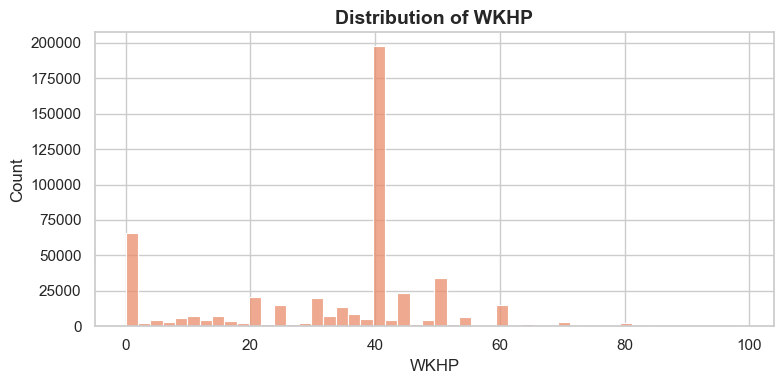

In [46]:

sns.set_theme(style="whitegrid", palette="flare")

for col in numeric_cols:
    plt.figure(figsize=(8, 4))
    sns.histplot(insurance_data[col], bins=50, kde=False, color=sns.color_palette("flare")[0])
    plt.title(f'Distribution of {col}', fontsize=14, weight='bold')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()


### Categorical value visualization

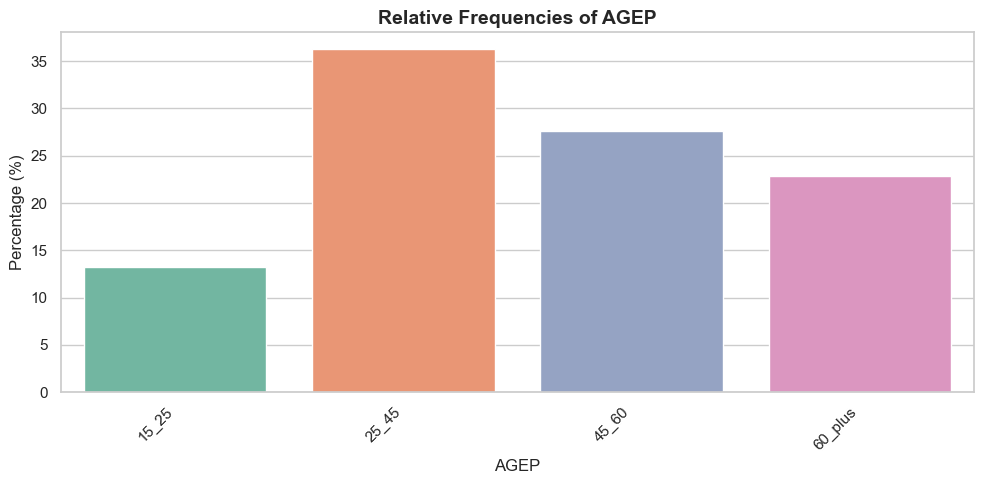

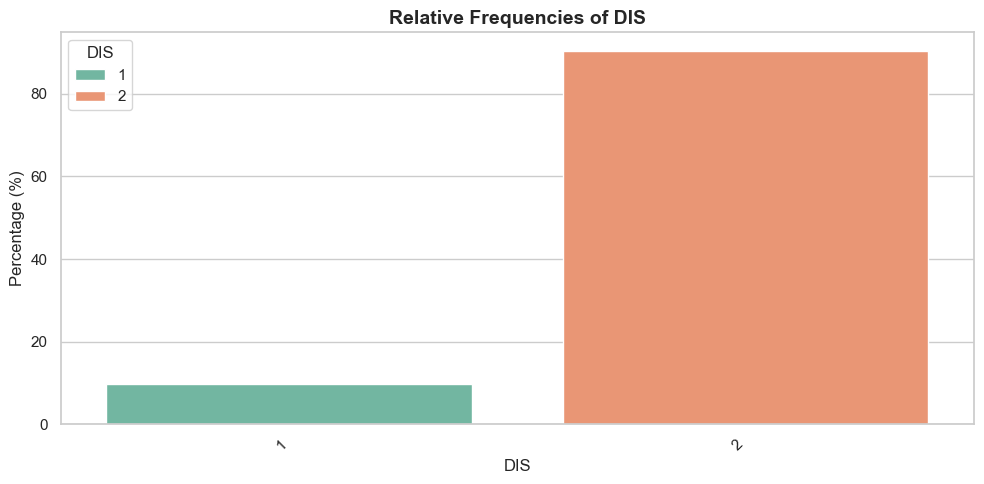

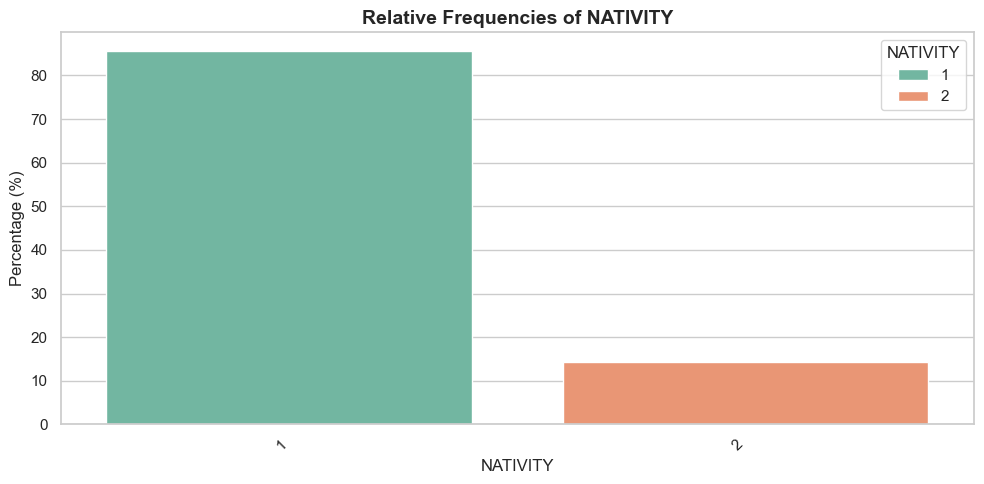

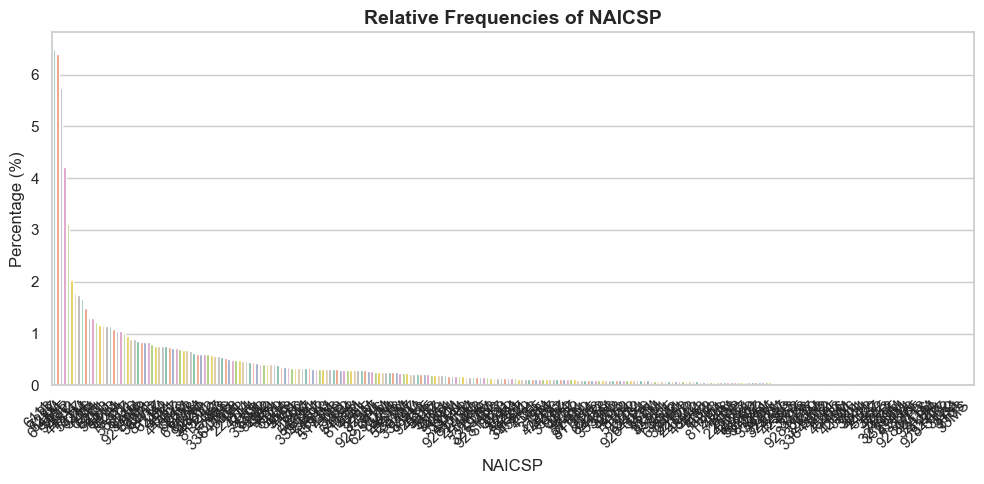

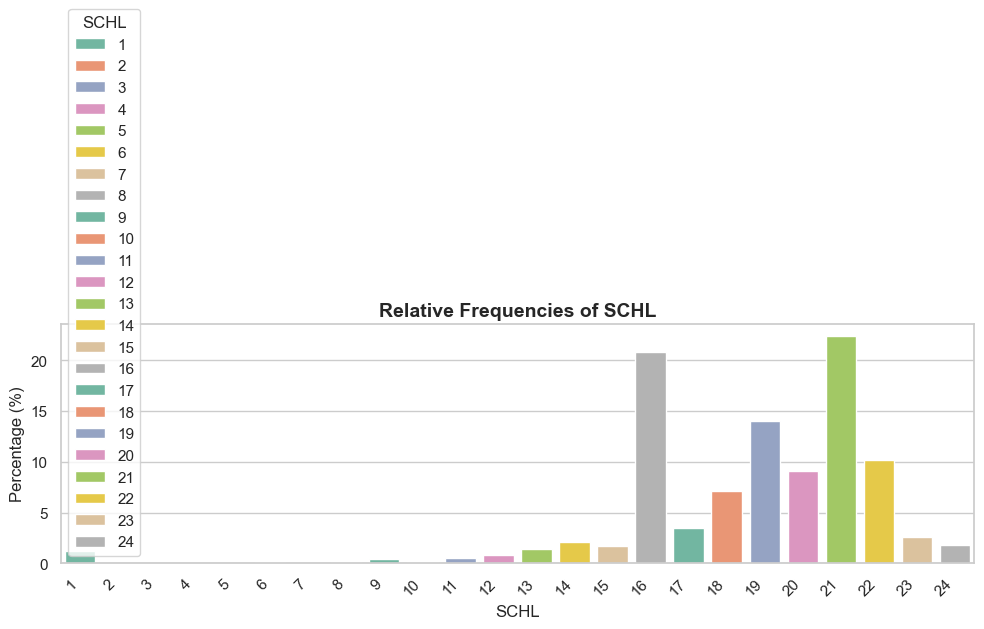

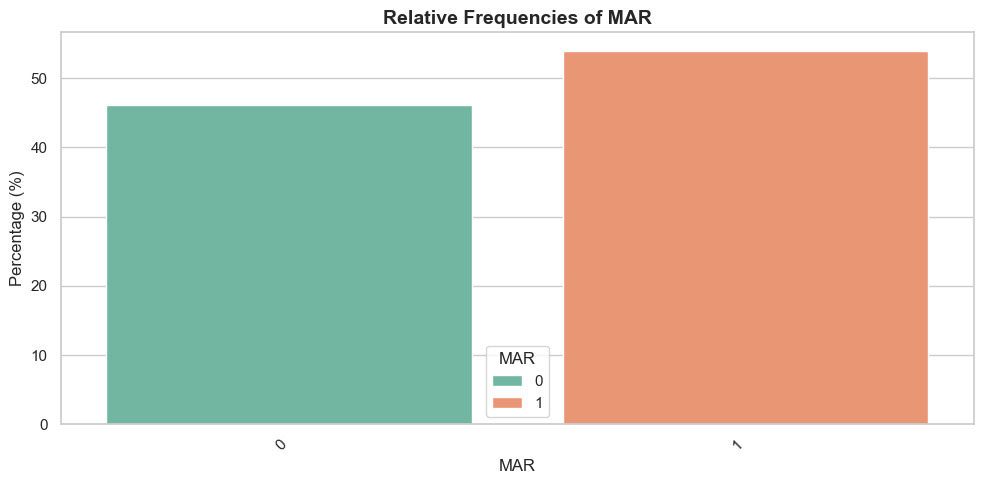

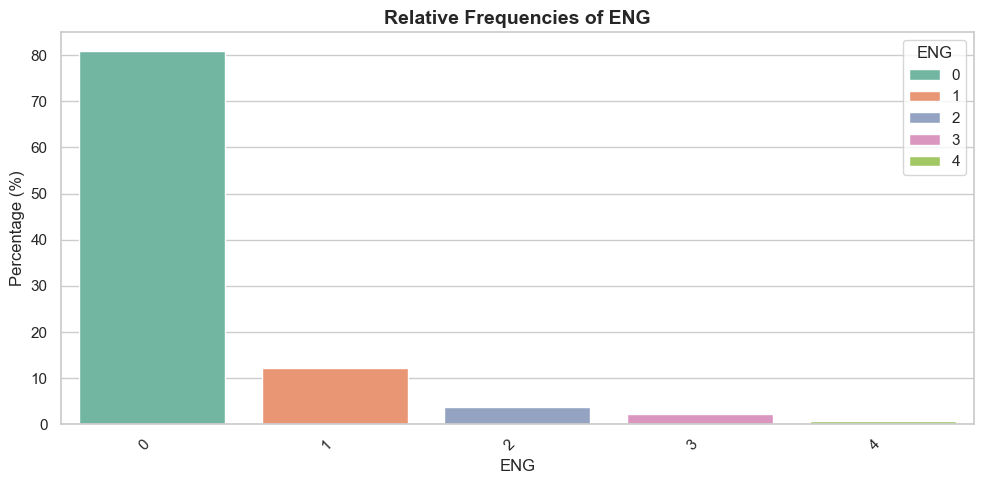

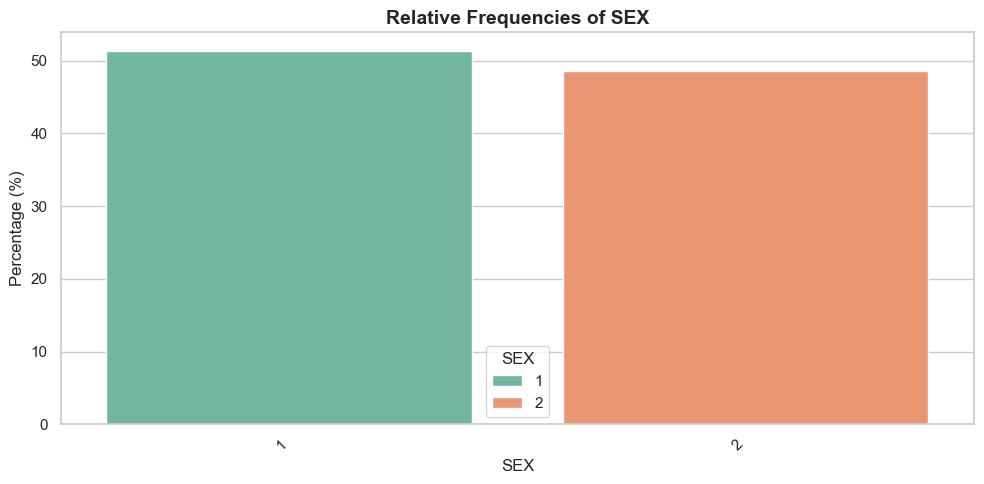

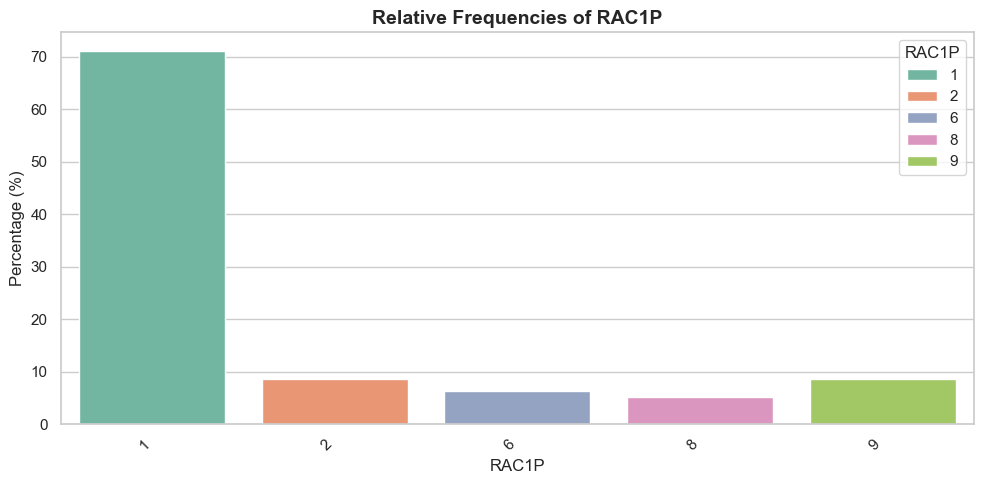

In [47]:
sns.set_theme(style="whitegrid", palette="Set2")

limit_top_n = 30
columns_to_limit = ['OCCP', 'POBP'] 


for col in categorical_cols:
    plt.figure(figsize=(10, 5))

    # value counts normalized
    value_counts = insurance_data[col].value_counts(normalize=True) * 100
    
    if col in columns_to_limit:
        value_counts = value_counts.head(limit_top_n)

    plot_df = value_counts.reset_index()
    plot_df.columns = [col, 'percentage']

    sns.barplot(data=plot_df, x=col, y='percentage', hue=col, palette="Set2")
    
    plt.title(f'Relative Frequencies of {col}', fontsize=14, weight='bold')
    plt.xlabel(col)
    plt.ylabel('Percentage (%)')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

## Creating thresholds and splitting datasets

### Income dataset

In [7]:
def preprocess_income_data(df, threshold):
    df_copy = df.copy()
    df_copy['binary_target'] = (df_copy['target'] >= threshold).astype(int)
    y = df_copy['binary_target']
    X = df_copy.drop(columns=['target', 'binary_target'], errors='ignore')

    return X, y


preprocessor1 = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=True), categorical_cols)
    ],
    remainder='passthrough' 
)

threshold = 50000
X, y = preprocess_income_data(income_data, threshold)

# tempsplit: train (70%) and temp (30%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# final split: validation (15%) and test (15%) from temp
X_val, X_test_inc, y_val, y_test_income = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

preprocessor1.fit(X_train)

X_train_income = preprocessor1.transform(X_train)
X_val_income   = preprocessor1.transform(X_val)
X_test_income  = preprocessor1.transform(X_test_inc)


In [8]:
print(X.columns)

Index(['RAC1P', 'SEX', 'MAR', 'DIS', 'NAICSP', 'SCHL', 'AGEP', 'WKHP'], dtype='object')


In [8]:
y_train_income = y_train.to_numpy() if hasattr(y_train, "to_numpy") else y_train
y_val_income = y_val.to_numpy() if hasattr(y_val, "to_numpy") else y_val

### Health care dataset

In [9]:
def preprocess_healthcare_data(df):
    df_copy = df.copy()
    
    # Convert target values: 1 → 1 (with insurance), 2 → 0 (no insurance)
    df_copy['binary_target'] = (df_copy['target'] == 1).astype(int)

    # Separate features and target
    X = df_copy.drop(columns=['target', 'binary_target'], errors='ignore')
    y = df_copy['binary_target']
    
    return X, y

# Define the column transformer
preprocessor2 = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=True), categorical_cols)
    ],
    remainder='passthrough'
)

# Run preprocessing
X, y = preprocess_healthcare_data(insurance_data)

# Split: train (70%) and temp (30%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Split: validation (15%) and test (15%)
X_val, X_test_h, y_val, y_test_health = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

# Fit and transform
preprocessor2.fit(X_train)

X_train_health = preprocessor2.transform(X_train)
X_val_health   = preprocessor2.transform(X_val)
X_test_health  = preprocessor2.transform(X_test_h)


In [10]:
y_train_health = y_train.to_numpy() if hasattr(y_train, "to_numpy") else y_train
y_val_health = y_val.to_numpy() if hasattr(y_val, "to_numpy") else y_val

In [11]:
income_feature_names = preprocessor1.named_transformers_['cat'].get_feature_names_out(categorical_cols)
health_feature_names = preprocessor2.named_transformers_['cat'].get_feature_names_out(categorical_cols)
numeric_cols_health =  ['AGEP', 'WKHP', 'PINCP']
all_feature_names_income = list(income_feature_names) + numeric_cols
all_feature_names_health = list(health_feature_names) + numeric_cols_health

In [13]:
print(len(all_feature_names_income))

304


In [14]:
print(X_test_income.shape)

(75000, 304)


### Linear baseline model for performance comparison ?

In [ ]:
#logreg = LogisticRegression(solver= 'saga', class_weight='balanced', max_iter=2500)
#logreg.fit(X_train_enc, y_train)
#y_pred_logreg = logreg.predict(X_test_enc)
#print(classification_report(y_test, y_pred_logreg))


## XGBoost Classifier

In [15]:
def tune_xgb_classifier(X_train, y_train, X_val, y_val, X_test, y_test, n_iter=20, random_state=42):
    param_dist = {
        'n_estimators': randint(100, 700),
        'max_depth': randint(3, 15),
        'learning_rate': uniform(0.01, 0.3),
        'subsample': uniform(0.5, 0.5),
        'colsample_bytree': uniform(0.5, 0.5),
        'gamma': uniform(0, 5),
        'reg_alpha': uniform(0, 1),
        'reg_lambda': uniform(0, 1),
    }

    param_list = list(ParameterSampler(param_dist, n_iter=n_iter, random_state=random_state))
    results = []

    for i, params in enumerate(param_list):
        print(f"\n Running trial {i+1}/{n_iter}...")
        print("Params:", params)
        start = time.time()

        model = XGBClassifier(eval_metric='logloss', n_jobs=-1, **params)
        model.fit(X_train, y_train)
        y_val_pred = model.predict(X_val)
        val_f1 = f1_score(y_val, y_val_pred, average='macro')

        duration = time.time() - start
        print(f"Finished trial {i+1}/{n_iter} — Val F1 (macro): {val_f1:.4f} — Time: {duration:.1f}s")

        results.append((params, val_f1))

    best_params, best_score = max(results, key=lambda x: x[1])
    print("\nBest Hyperparameters:", best_params)
    print(f"Best Validation F1 (macro): {best_score:.4f}")

    # Train best model on full training data
    best_model = XGBClassifier(eval_metric='logloss', n_jobs=-1, **best_params)
    best_model.fit(X_train, y_train)

    y_test_pred = best_model.predict(X_test)
    print("\nFinal Test Set Performance:")
    print(classification_report(y_test, y_test_pred))

    return best_model, best_params, best_score


In [16]:
# For income prediction
xgmodel_income, params_income, score_income = tune_xgb_classifier(
    X_train_income, y_train_income, X_val_income, y_val_income, X_test_income, y_test_income
)

# For healthcare prediction
xgmodel_health, params_health, score_health = tune_xgb_classifier(
    X_train_health, y_train_health, X_val_health, y_val_health, X_test_health, y_test_health
)



 Running trial 1/20...
Params: {'colsample_bytree': np.float64(0.6872700594236812), 'gamma': np.float64(4.75357153204958), 'learning_rate': np.float64(0.22959818254342154), 'max_depth': 7, 'n_estimators': 221, 'reg_alpha': np.float64(0.15599452033620265), 'reg_lambda': np.float64(0.05808361216819946), 'subsample': np.float64(0.9330880728874675)}
Finished trial 1/20 — Val F1 (macro): 0.7860 — Time: 3.2s

 Running trial 2/20...
Params: {'colsample_bytree': np.float64(0.8005575058716043), 'gamma': np.float64(3.540362888980227), 'learning_rate': np.float64(0.016175348288740735), 'max_depth': 4, 'n_estimators': 443, 'reg_alpha': np.float64(0.8324426408004217), 'reg_lambda': np.float64(0.21233911067827616), 'subsample': np.float64(0.5909124836035503)}
Finished trial 2/20 — Val F1 (macro): 0.7702 — Time: 6.3s

 Running trial 3/20...
Params: {'colsample_bytree': np.float64(0.5917022549267169), 'gamma': np.float64(1.5212112147976886), 'learning_rate': np.float64(0.16742692948967136), 'max_dept

In [17]:
print(params_income)

{'colsample_bytree': np.float64(0.5806106436270022), 'gamma': np.float64(4.648488261712865), 'learning_rate': np.float64(0.2524361138693251), 'max_depth': 11, 'n_estimators': 127, 'reg_alpha': np.float64(0.2184404372168336), 'reg_lambda': np.float64(0.4165099478703662), 'subsample': np.float64(0.9416401294594341)}


In [33]:
params_income = {'colsample_bytree': np.float64(0.6872700594236812), 'gamma': np.float64(4.75357153204958), 'learning_rate': np.float64(0.22959818254342154), 'max_depth': 7, 'n_estimators': 221, 'reg_alpha': np.float64(0.15599452033620265), 'reg_lambda': np.float64(0.05808361216819946), 'subsample': np.float64(0.9330880728874675)}

In [18]:
print(params_health)

{'colsample_bytree': np.float64(0.6943386448447411), 'gamma': np.float64(1.3567451588694794), 'learning_rate': np.float64(0.2586212527455788), 'max_depth': 12, 'n_estimators': 316, 'reg_alpha': np.float64(0.28093450968738076), 'reg_lambda': np.float64(0.5426960831582485), 'subsample': np.float64(0.5704621124873813)}


In [34]:
params_health = {'colsample_bytree': np.float64(0.8477580432130638), 'gamma': np.float64(0.6966572720293784), 'learning_rate': np.float64(0.1913252137833452), 'max_depth': 13, 'n_estimators': 640, 'reg_alpha': np.float64(0.22879816549162246), 'reg_lambda': np.float64(0.07697990982879299), 'subsample': np.float64(0.6448757264568841)}

## TreeSHAP

### Income classifier

In [19]:
#params_income = {'colsample_bytree': np.float64(0.5911180438940311), 'gamma': np.float64(3.7768070515882624), 'learning_rate': np.float64(0.13754676234737342), 'max_depth': 8, 'n_estimators': 205, 'reg_alpha': np.float64(0.5677003278199915), 'reg_lambda': np.float64(0.03131329245555858), 'subsample': np.float64(0.9211423872974993)}

best_model_income = XGBClassifier(
    eval_metric='logloss',
    n_jobs=-1,
    **params_income
)
best_model_income.fit(X_train_income, y_train_income)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=np.float64(0.5806106436270022), device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None, feature_weights=None,
              gamma=np.float64(4.648488261712865), grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=np.float64(0.2524361138693251), max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=11, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=127, n_jobs=-1,
              num_parallel_tree=None, ...)

In [20]:
print(y_test_income.shape)

(75000,)


In [22]:
# income
y_pred_income = best_model_income.predict(X_test_income)
y_pred_proba_income = best_model_income.predict_proba(X_test_income)[:, 1] 


print("Accuracy:", accuracy_score(y_test_income, y_pred_income))
print("Classification Report:\n", classification_report(y_test_income, y_pred_income))



Accuracy: 0.7917333333333333
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.83      0.82     43688
           1       0.75      0.74      0.75     31312

    accuracy                           0.79     75000
   macro avg       0.79      0.79      0.79     75000
weighted avg       0.79      0.79      0.79     75000



In [103]:
eval_df_income = X_test_inc.copy()
eval_df_income["y_true"] = y_test_income.values
eval_df_income["y_pred"] = y_pred_income


In [93]:
inc1 = preprocessor1.get_feature_names_out()

# Remove "cat__" and "remainder__"
clean_feature_names = [name.replace("cat__", "").replace("remainder__", "") for name in inc1]


In [95]:
results_df = pd.DataFrame(X_test_income.toarray(), columns=clean_feature_names)

# Add target and predictions
results_df['y_true'] = y_test_income.values
results_df['y_pred'] = y_pred_income
results_df['y_pred_proba'] = y_pred_proba_income

# Save to CSV
results_df.to_csv('income_test_predictions.csv', index=False)

In [24]:
income_explainer = shap.Explainer(best_model_income, feature_names = all_feature_names_income)
shap_values_income = income_explainer(X_test_income)

In [25]:
# locally saving shap values
np.save("treeshap_values_income.npy", shap_values_income.values)

with open("treeshap_values_income.pkl", "wb") as f:
    pickle.dump(shap_values_income, f)

In [28]:
mean_abs_shap_income = np.abs(shap_values_income.values).mean(axis=0)

top_20_idx = np.argsort(mean_abs_shap_income)[-20:][::-1]

original_feature_names = shap_values_income.feature_names
top_20_features = np.array(original_feature_names)[top_20_idx]

custom_names = {
    'PINCP': 'Income',
    'WKHP': 'Hours worked per week',
    'AGEP_25_45': 'Age 25 to 45',
    'AGEP_18_25': 'Age 18 to 25',
    'AGEP_45_60': 'Age 45 to 50',
    'AGEP_60_plus': 'Age above 60',
    'SEX_1': 'Male',
    'SEX_2': 'Female',
    'MAR_1': 'Married', 
    'SCHL_21': 'Bachelors Degree',
    'SCHL_16':'Regular high school diploma',
    'SCHL_23':'Professional degree beyond a bachelor\'s degree',
    'DIS_1': 'With Disability',
    'SCHL_22': 'Masters Degree',
    'MAR_0': 'Not married',
    'RAC1P_1': 'Caucasian',
    'NAICSP_722Z': 'Food Services And Drinking Places, Except Alcoholic Drinks',
    'DIS_2': 'Without Disability',
    'RAC1P_2': 'African-American',
    'SCHL_24': 'Doctorate Degree',
    'NAICSP_622M': 'General Medical And Surgical Hospitals',
    'NAICSP_6111': 'Elementary And Secondary Schools',
    'NAICSP_5415': 'Computer Systems Design and Related Services'
}


renamed_features = [
    custom_names.get(name, name)
    for name in original_feature_names
]
shap_values_income.feature_names = renamed_features

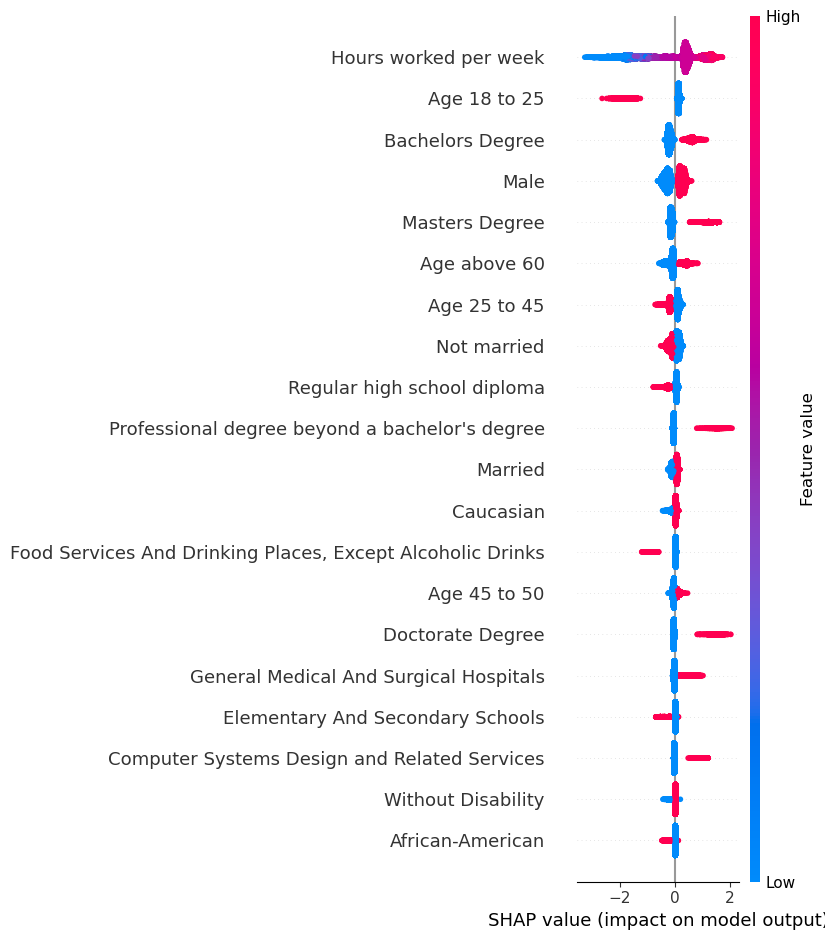

In [29]:
X_test_income_df = pd.DataFrame(X_test_income.toarray(), columns=original_feature_names)  # Use toarray() if sparse

X_test_income_df.columns = renamed_features

shap.summary_plot(shap_values_income, X_test_income_df, max_display=20)


### Health care classifier

In [30]:
#params_health = {'colsample_bytree': np.float64(0.7248770666848828), 'gamma': np.float64(1.9757511800090721), 'learning_rate': np.float64(0.28799765973813823), 'max_depth': 10, 'n_estimators': 561, 'reg_alpha': np.float64(0.1959828624191452), 'reg_lambda': np.float64(0.045227288910538066), 'subsample': np.float64(0.6626651653816322)}

best_model_health = XGBClassifier(
    eval_metric='logloss',
    n_jobs=-1,
    **params_health
)
best_model_health.fit(X_train_health, y_train_health)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=np.float64(0.6943386448447411), device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None, feature_weights=None,
              gamma=np.float64(1.3567451588694794), grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=np.float64(0.2586212527455788), max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=12, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=316, n_jobs=-1,
              num_parallel_tree=None, ...)

In [31]:
health_explainer = shap.Explainer(best_model_health, feature_names = all_feature_names_health)
shap_values_health = health_explainer(X_test_health)

In [32]:
# locally savin gshap values

np.save("treeshap_values_health.npy", shap_values_health.values)

with open("treeshap_values_health.pkl", "wb") as f:
    pickle.dump(shap_values_health, f)

In [33]:
y_pred_health = best_model_health.predict(X_test_health)
y_pred_proba_health = best_model_health.predict_proba(X_test_health)[:, 1] 


print("Accuracy:", accuracy_score(y_test_health, y_pred_health))
print("Classification Report:\n", classification_report(y_test_health, y_pred_health))

Accuracy: 0.9111733333333333
Classification Report:
               precision    recall  f1-score   support

           0       0.48      0.13      0.20      6578
           1       0.92      0.99      0.95     68422

    accuracy                           0.91     75000
   macro avg       0.70      0.56      0.58     75000
weighted avg       0.88      0.91      0.89     75000



In [104]:
eval_df_health = X_test_h.copy()
eval_df_health["y_true"] = y_test_health.values
eval_df_health["y_pred"] = y_pred_health


In [97]:
inc2 = preprocessor2.get_feature_names_out()

# Remove "cat__" and "remainder__"
clean_feature_names2 = [name.replace("cat__", "").replace("remainder__", "") for name in inc2]


In [98]:
results_df = pd.DataFrame(X_test_health.toarray(), columns=clean_feature_names2)

results_df['y_true'] = y_test_health.values
results_df['y_pred'] = y_pred_health
results_df['y_pred_proba'] = y_pred_proba_health

results_df.to_csv('health_test_predictions_XGBoost.csv', index=False)

In [43]:
mean_abs_shap_health = np.abs(shap_values_health.values).mean(axis=0)

top_20_idx = np.argsort(mean_abs_shap_health)[-20:][::-1]

original_feature_names = shap_values_health.feature_names
top_20_features = np.array(original_feature_names)[top_20_idx]

custom_names = {
    'PINCP': 'Income',
    'WKHP': 'Hours worked per week',
    'AGEP': 'Age',
    'SEX_1': 'Male',
    'SEX_2': 'Female',
    'SCHL_21': 'Bachelors Degree',
    'SCHL_16':'Regular high school diploma',
    'SCHL_23':'Professional degree beyond a bachelor\'s degree',
    'DIS_1': 'With Disability',
    'SCHL_22': 'Masters Degree',
    'NAICSP_23': 'Construction',
    'PINCP': 'Income',
    'WKHP': 'Hours worked per week',
    'AGEP_25_45': 'Age 25 to 45',
    'AGEP_18_25': 'Age 18 to 25',
    'AGEP_60_plus': 'Age above 60',
    'MAR_1': 'Married', 
    'SCHL_21': 'Bachelors Degree',
    'SCHL_16':'Regular high school diploma',
    'SCHL_23':'Professional degree beyond a bachelor\'s degree',
    'DIS_1': 'With Disability',
    'SCHL_22': 'Masters Degree',
    'MAR_0': 'Not married',
    'RAC1P_1': 'Caucasian',
    'NAICSP_722Z': 'Food Services And Drinking Places, Except Alcoholic Drinks',
    'DIS_2': 'Without Disability',
    'RAC1P_2': 'African-American',
    'SCHL_24': 'Doctorate Degree',
    'NAICSP_622M': 'General Medical And Surgical Hospitals',
    'NAICSP_6111': 'Elementary And Secondary Schools',
    'NAICSP_5415': 'Computer Systems Design and Related Services',
    'AGEP_45_60': 'Age 45 to 50',
    'RAC1P_8': 'Some Other Race Alone',
    'SCHL_19':'1 or more years of college credit, no diploma',
    'SCHL_20':'Associate\'s Degree'
}



renamed_features = [
    custom_names.get(name, name)
    for name in original_feature_names
]
shap_values_health.feature_names = renamed_features

In [44]:
print(X_test_health.toarray().shape)              # Should be (75000, 312)
print(len(original_feature_names))                # Should be 312
print(len(renamed_features))                      # Should be 312
original_feature_names = original_feature_names[:305]
renamed_features = renamed_features[:305]


(75000, 305)
306
306


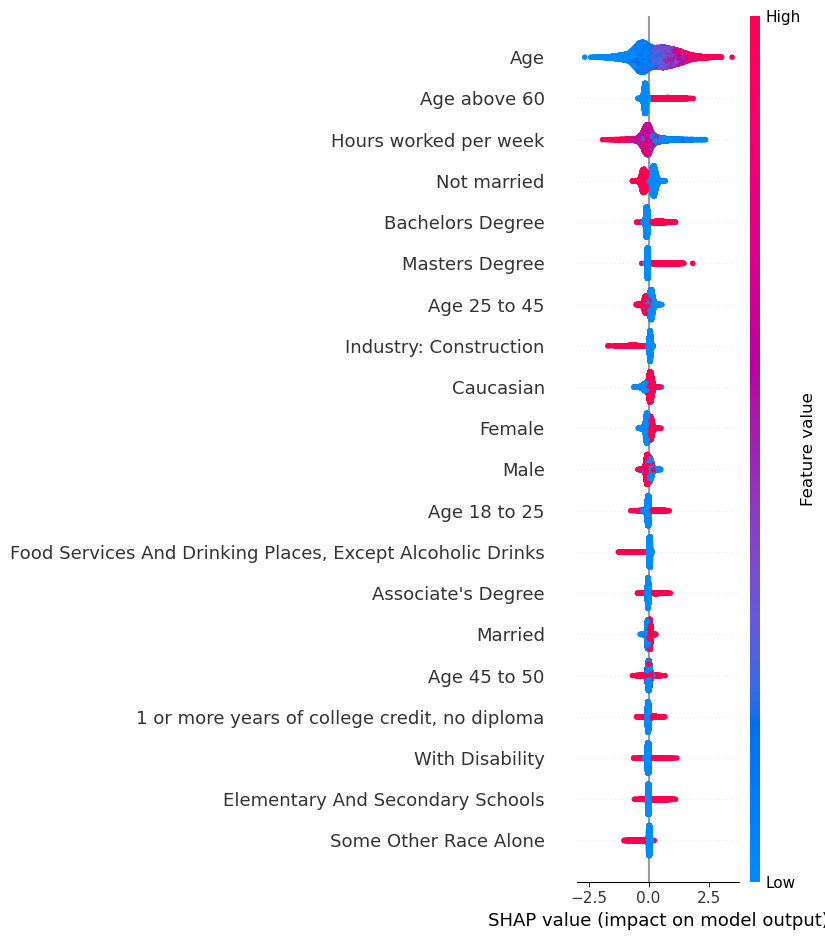

In [45]:
X_test_health_df = pd.DataFrame(X_test_health.toarray(), columns=original_feature_names)  # Use toarray() if sparse

X_test_health_df.columns = renamed_features

shap.summary_plot(shap_values_health, X_test_health_df, max_display=20)

## Simple FFNN

In [175]:
def build_ffnn(input_dim, hidden_units=64, dropout_rate=0.5, learning_rate=0.001):
    model = Sequential()
    model.add(Input(shape=(input_dim,)))   # Input layer, preferred way
    model.add(Dense(hidden_units, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(hidden_units // 2, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))  # Binary classification output

    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['AUC']
    )
    return model

def train_ffnn_for_task(X_train, y_train, X_val, y_val, input_dim, n_iter=10, random_state=42):
    np.random.seed(random_state)

    param_dist = {
        'hidden_units': [32, 64],
        'dropout_rate': [0.2, 0.3, 0.4],
        'learning_rate': [1e-2, 1e-3, 1e-4],
        'batch_size': [32, 64],
        'epochs': [10, 20]
    }

    def sample_params(param_dist):
        return {k: np.random.choice(v) for k, v in param_dist.items()}

    cw = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weights = dict(zip(np.unique(y_train), cw))

    results = []

    for i in range(n_iter):
        params = sample_params(param_dist)
        print(f"Trial {i+1}/{n_iter} with params: {params}")

        model = build_ffnn(
            input_dim=input_dim,
            hidden_units=params['hidden_units'],
            dropout_rate=params['dropout_rate'],
            learning_rate=params['learning_rate']
        )

        model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=params['epochs'],
            batch_size=params['batch_size'],
            verbose=0,
            class_weight=class_weights
        )

        val_preds = model.predict(X_val).ravel()
        val_auc = roc_auc_score(y_val, val_preds)
        print(f"Val AUC: {val_auc:.4f}\n")

        results.append((params, val_auc))

    best_params, best_val_auc = max(results, key=lambda x: x[1])
    print(f" Best Params: {best_params}\n Best Val AUC: {best_val_auc:.4f}")

    # Train best model on full data (optionally)
    best_model = build_ffnn(
        input_dim=input_dim,
        hidden_units=best_params['hidden_units'],
        dropout_rate=best_params['dropout_rate'],
        learning_rate=best_params['learning_rate']
    )

    best_model.fit(
        X_train, y_train,
        epochs=best_params['epochs'],
        batch_size=best_params['batch_size'],
        verbose=0,
        class_weight=class_weights
    )

    return best_model, best_params, best_val_auc


In [ ]:
input_dim_income = X_train_income.shape[1]
print("\n=== Training for Task: Insurance ===")
ffnn_model_income, params_income, auc_income = train_ffnn_for_task(
    X_train_income, y_train_income, X_val_income, y_val_income, input_dim_income
)

### Income model with given params

In [14]:
# income
best_params_income = {'hidden_units': np.int64(128), 'dropout_rate': np.float64(0.2), 'learning_rate': np.float64(0.0001), 'batch_size': np.int64(32), 'epochs': np.int64(20)}

In [ ]:
ffnn_model_income = build_ffnn(
    input_dim=X_train_income.shape[1],  # or whatever your feature dim is
    hidden_units=int(best_params_income['hidden_units']),
    dropout_rate=float(best_params_income['dropout_rate']),
    learning_rate=float(best_params_income['learning_rate'])
)

In [16]:
cw = class_weight.compute_class_weight('balanced', classes=np.unique(y_train_income), y=y_train_income)
class_weights = dict(zip(np.unique(y_train_income), cw))

ffnn_model_income.fit(
    X_train_income, y_train_income,
    epochs=int(best_params_income['epochs']),
    batch_size=int(best_params_income['batch_size']),
    class_weight=class_weights,
    verbose=1,
    validation_data=(X_val_income, y_val_income)
)


Epoch 1/20
10938/10938 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step - AUC: 0.7929 - loss: 0.5427 - val_AUC: 0.8664 - val_loss: 0.4498
Epoch 2/20
10938/10938 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step - AUC: 0.8637 - loss: 0.4577 - val_AUC: 0.8698 - val_loss: 0.4472
Epoch 3/20
10938/10938 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step - AUC: 0.8682 - loss: 0.4508 - val_AUC: 0.8712 - val_loss: 0.4422
Epoch 4/20
10938/10938 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step - AUC: 0.8703 - loss: 0.4469 - val_AUC: 0.8727 - val_loss: 0.4434
Epoch 5/20
10938/10938 ━━━━━━━━━━━━━━━━━━━━ 24s 2ms/step - AUC: 0.8720 - loss: 0.4438 - val_AUC: 0.8730 - val_loss: 0.4469
Epoch 6/20
10938/10938 ━━━━━━━━━━━━━━━━━━━━ 24s 2ms/step - AUC: 0.8737 - loss: 0.4413 - val_AUC: 0.8740 - val_loss: 0.4411
Epoch 7/20
10938/10938 ━━━━━━━━━━━━━━━━━━━━ 24s 2ms/step - AUC: 0.8728 - loss: 0.4430 - val_AUC: 0.8739 - val_loss: 0.4428
Epoch 8/20
10938/10938 ━━━━━━━━━━━━━━━━━━━━ 24s 2ms/step - AUC: 0.8744 - loss: 0.4407 - val_AUC: 0.8736 - val_loss: 0.4383
Epoch 9/20
10938

In [35]:
ffnn_model_income.save('ffnn_income.keras')

In [176]:
input_dim_health = X_train_health.shape[1]
print("\n=== Training for Task: Insurance ===")
ffnn_model_health, params_health, auc_health = train_ffnn_for_task(
    X_train_health, y_train_health, X_val_health, y_val_health, input_dim_health
)


=== Training for Task: Insurance ===
Trial 1/10 with params: {'hidden_units': np.int64(32), 'dropout_rate': np.float64(0.2), 'learning_rate': np.float64(0.0001), 'batch_size': np.int64(32), 'epochs': np.int64(20)}
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
Val AUC: 0.6905

Trial 2/10 with params: {'hidden_units': np.int64(32), 'dropout_rate': np.float64(0.2), 'learning_rate': np.float64(0.0001), 'batch_size': np.int64(64), 'epochs': np.int64(10)}
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
Val AUC: 0.7545

Trial 3/10 with params: {'hidden_units': np.int64(32), 'dropout_rate': np.float64(0.4), 'learning_rate': np.float64(0.0001), 'batch_size': np.int64(64), 'epochs': np.int64(10)}
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
Val AUC: 0.4201

Trial 4/10 with params: {'hidden_units': np.int64(64), 'dropout_rate': np.float64(0.4), 'learning_rate': np.float64(0.001), 'batch_size': np.int64(32), 'epochs': np.int64(20)}
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
Val AUC: 0.5516

Trial 5/10 with

### Health insurance model with given params

In [178]:
# health
best_params_health = {'hidden_units': np.int64(32), 'dropout_rate': np.float64(0.2), 'learning_rate': np.float64(0.0001), 'batch_size': np.int64(64), 'epochs': np.int64(10)}
 #Best Val AUC: 0.8816

In [179]:
ffnn_model_health = build_ffnn(
    input_dim=X_train_health.shape[1],  # or whatever your feature dim is
    hidden_units=int(best_params_health['hidden_units']),
    dropout_rate=float(best_params_health['dropout_rate']),
    learning_rate=float(best_params_health['learning_rate'])
)

In [180]:
cw = class_weight.compute_class_weight('balanced', classes=np.unique(y_train_health), y=y_train_health)
class_weights = dict(zip(np.unique(y_train_health), cw))

ffnn_model_health.fit(
    X_train_health, y_train_health,
    epochs=int(best_params_health['epochs']),
    batch_size=int(best_params_health['batch_size']),
    class_weight=class_weights,
    verbose=1,
    validation_data=(X_val_health, y_val_health)
)

Epoch 1/10
5469/5469 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - AUC: 0.5217 - loss: 109.9372 - val_AUC: 0.7263 - val_loss: 0.6724
Epoch 2/10
5469/5469 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - AUC: 0.5795 - loss: 4.5616 - val_AUC: 0.6913 - val_loss: 0.7413
Epoch 3/10
5469/5469 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - AUC: 0.6324 - loss: 0.9254 - val_AUC: 0.6898 - val_loss: 0.9209
Epoch 4/10
5469/5469 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - AUC: 0.6646 - loss: 0.6811 - val_AUC: 0.6914 - val_loss: 0.7566
Epoch 5/10
5469/5469 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - AUC: 0.6768 - loss: 0.6593 - val_AUC: 0.6973 - val_loss: 0.6705
Epoch 6/10
5469/5469 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - AUC: 0.6546 - loss: 0.6670 - val_AUC: 0.6952 - val_loss: 0.6090
Epoch 7/10
5469/5469 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - AUC: 0.6506 - loss: 0.6632 - val_AUC: 0.7087 - val_loss: 0.6757
Epoch 8/10
5469/5469 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - AUC: 0.6629 - loss: 0.6561 - val_AUC: 0.7057 - val_loss: 0.6288
Epoch 9/10
5469/5469 ━━━━━━━━━━

In [213]:
ffnn_model_health.save('ffnn_health.keras')

In [ ]:
print("\n=== Test Performance: Income ===")
test_preds_income = ffnn_model_income.predict(X_test_income).ravel()
test_auc_income = roc_auc_score(y_test_income, test_preds_income)
print(f"Test AUC: {test_auc_income:.4f}")
print(classification_report(y_test_income, test_preds_income > 0.5))

In [181]:
# test set evluation


print("\n=== Test Performance: Insurance ===")
test_preds_health = ffnn_model_health.predict(X_test_health).ravel()
test_auc_health = roc_auc_score(y_test_health, test_preds_health)
print(f"Test AUC: {test_auc_health:.4f}")
print(classification_report(y_test_health, test_preds_health > 0.5))



=== Test Performance: Insurance ===
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
Test AUC: 0.7444
              precision    recall  f1-score   support

           0       0.14      0.84      0.24      6578
           1       0.97      0.51      0.67     68422

    accuracy                           0.54     75000
   macro avg       0.56      0.67      0.46     75000
weighted avg       0.90      0.54      0.63     75000



In [ ]:
np.savez(
    "ffnn_income_data.npz",
    X_test=X_test_income.toarray() if hasattr(X_test_income, 'toarray') else X_test_income,
    y_true=y_test_income,
    y_pred=test_preds_income
)

In [182]:
np.savez(
    "ffnn_health_data.npz",
    X_test=X_test_health.toarray() if hasattr(X_test_health, 'toarray') else X_test_health,
    y_true=y_test_health,
    y_pred=test_preds_health)


## DeepSHAP

### Income

c:\Users\odiee\anaconda3\envs\hcml2\lib\site-packages\shap\explainers\_deep\deep_tf.py:94: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn(
c:\Users\odiee\anaconda3\envs\hcml2\lib\site-packages\keras\src\models\functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_11
Received: inputs=['Tensor(shape=(5000, 304))']
  warnings.warn(msg)
c:\Users\odiee\anaconda3\envs\hcml2\lib\site-packages\keras\src\models\functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_11
Received: inputs=['Tensor(shape=(10000, 304))']
  warnings.warn(msg)
C:\Users\odiee\AppData\Local\Temp\ipykernel_14980\3842460246.py:23: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no 

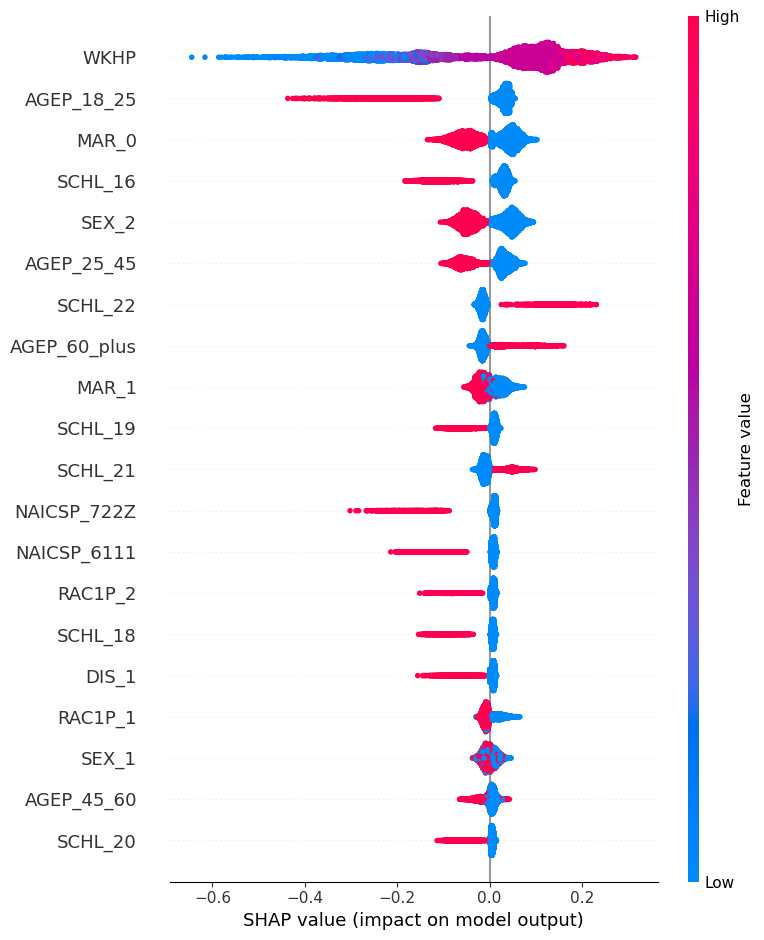

In [56]:
# sample representative background set and sample size
background_size = 5000
test_sample_size = 10000
 
# stratified sample from training set
sss_train = StratifiedShuffleSplit(n_splits=1, test_size=background_size, random_state=42)
_ , background_idx = next(sss_train.split(X_train_income, y_train_income))
 
# stratified sample from test set
X_test_array = X_test_income.toarray() if hasattr(X_test_income, "toarray") else X_test_income
sss_test = StratifiedShuffleSplit(n_splits=1, test_size=test_sample_size, random_state=42)
_, test_sample_idx_income = next(sss_test.split(X_test_array, y_test_income))
X_test_sample_income = X_test_array[test_sample_idx_income]
 
# set background
background = X_train_income[background_idx]
background = background.toarray() if hasattr(background, "toarray") else background
 
# DeepSHAP
explainer_income_NN = shap.DeepExplainer(ffnn_model_income, background)
deep_shap_values_income = explainer_income_NN.shap_values(X_test_sample_income).squeeze(-1)

shap.summary_plot(deep_shap_values_income, X_test_sample_income, feature_names=all_feature_names_income, max_display=20)


In [24]:
print(all_feature_names_income)

['AGEP_18_25', 'AGEP_25_45', 'AGEP_45_60', 'AGEP_60_plus', 'DIS_1', 'DIS_2', 'NAICSP_111', 'NAICSP_112', 'NAICSP_1133', 'NAICSP_113M', 'NAICSP_114', 'NAICSP_115', 'NAICSP_211', 'NAICSP_2121', 'NAICSP_2122', 'NAICSP_2123', 'NAICSP_213', 'NAICSP_2211P', 'NAICSP_2212P', 'NAICSP_22132', 'NAICSP_2213M', 'NAICSP_221MP', 'NAICSP_22S', 'NAICSP_23', 'NAICSP_3113', 'NAICSP_3114', 'NAICSP_3115', 'NAICSP_3116', 'NAICSP_311811', 'NAICSP_3118Z', 'NAICSP_311M1', 'NAICSP_311M2', 'NAICSP_311S', 'NAICSP_3121', 'NAICSP_3122', 'NAICSP_3131', 'NAICSP_3132Z', 'NAICSP_3133', 'NAICSP_31411', 'NAICSP_314Z', 'NAICSP_315M', 'NAICSP_3162', 'NAICSP_316M', 'NAICSP_31M', 'NAICSP_3211', 'NAICSP_3212', 'NAICSP_32199M', 'NAICSP_3219ZM', 'NAICSP_3221', 'NAICSP_32221', 'NAICSP_3222M', 'NAICSP_3231', 'NAICSP_32411', 'NAICSP_3241M', 'NAICSP_3252', 'NAICSP_3253', 'NAICSP_3254', 'NAICSP_3255', 'NAICSP_3256', 'NAICSP_325M', 'NAICSP_3261', 'NAICSP_32621', 'NAICSP_3262M', 'NAICSP_32711', 'NAICSP_32712', 'NAICSP_3272', 'NAICSP_3

In [29]:
custom_names = {
    'PINCP': 'Income',
    'WKHP': 'Hours worked per week',
    'AGEP': 'Age',
    'SEX_1': 'Male',
    'SEX_2': 'Female',
    'SCHL_21': 'Bachelors Degree',
    'SCHL_16':'Regular high school diploma',
    'SCHL_23':'Professional degree beyond a bachelor\'s degree',
    'DIS_1': 'With Disability',
    'SCHL_22': 'Masters Degree',
    'NAICSP_23': 'Construction',
    'PINCP': 'Income',
    'WKHP': 'Hours worked per week',
    'AGEP_25_45': 'Age 25 to 45',
    'AGEP_18_25': 'Age 18 to 25',
    'AGEP_60_plus': 'Age above 60',
    'MAR_1': 'Married', 
    'SCHL_21': 'Bachelors Degree',
    'SCHL_16':'Regular high school diploma',
    'SCHL_23':'Professional degree beyond a bachelor\'s degree',
    'DIS_1': 'With Disability',
    'SCHL_22': 'Masters Degree',
    'MAR_0': 'Not married',
    'RAC1P_1': 'Caucasian',
    'NAICSP_722Z': 'Food Services And Drinking Places, Except Alcoholic Drinks',
    'DIS_2': 'Without Disability',
    'RAC1P_2': 'African-American',
    'SCHL_24': 'Doctorate Degree',
    'NAICSP_622M': 'General Medical And Surgical Hospitals',
    'NAICSP_6111': 'Elementary And Secondary Schools',
    'NAICSP_5415': 'Computer Systems Design and Related Services',
    'AGEP_45_60': 'Age 45 to 50',
    'RAC1P_8': 'Some Other Race Alone',
    'SCHL_18':'Some College, Less Than One Year',
    'SCHL_19':'1 or more years of college credit, no diploma',
    'SCHL_20':'Associate\'s Degree'
}


# Map custom names to all features
renamed_features_income = [custom_names.get(name, name) for name in all_feature_names_income]

# Convert input data to a DataFrame with renamed columns
X_test_income_df = pd.DataFrame(X_test_sample_income, columns=renamed_features_income)


C:\Users\odiee\AppData\Local\Temp\ipykernel_14980\3121749230.py:2: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(deep_shap_values_income, X_test_income_df, max_display=20)


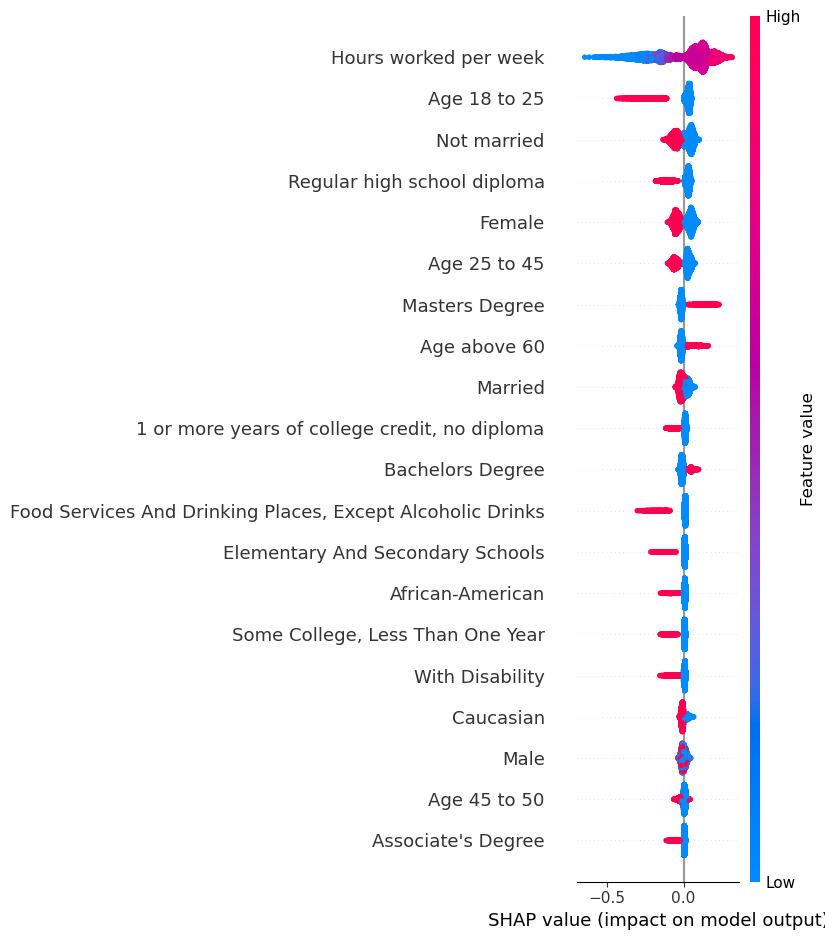

In [ ]:

shap.summary_plot(deep_shap_values_income, X_test_income_df, max_display=20)


In [214]:
# locally saving shap values
np.save("deepshap_values_income.npy", deep_shap_values_income)

with open("deepshap_values_income.pkl", "wb") as f:
    pickle.dump(deep_shap_values_income, f)

joblib.dump(deep_shap_values_income, "deepshap_explainer_income.joblib")

['deepshap_explainer_income.joblib']

In [ ]:
# Save test input
df_x_test_sample = pd.DataFrame(X_test_sample_income, columns=all_feature_names_income)
df_x_test_sample.to_csv('X_test_sample_income.csv', index=False)



In [37]:
df_x_background = pd.DataFrame(background, columns= all_feature_names_income)
df_x_background.to_csv('X_background_income.csv', index=False)

### Health insurance

c:\Users\odiee\anaconda3\envs\hcml2\lib\site-packages\shap\explainers\_deep\deep_tf.py:94: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn(
c:\Users\odiee\anaconda3\envs\hcml2\lib\site-packages\keras\src\models\functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_176
Received: inputs=['Tensor(shape=(5000, 305))']
  warnings.warn(msg)
c:\Users\odiee\anaconda3\envs\hcml2\lib\site-packages\keras\src\models\functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_176
Received: inputs=['Tensor(shape=(10000, 305))']
  warnings.warn(msg)
C:\Users\odiee\AppData\Local\Temp\ipykernel_14980\3677931467.py:23: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will n

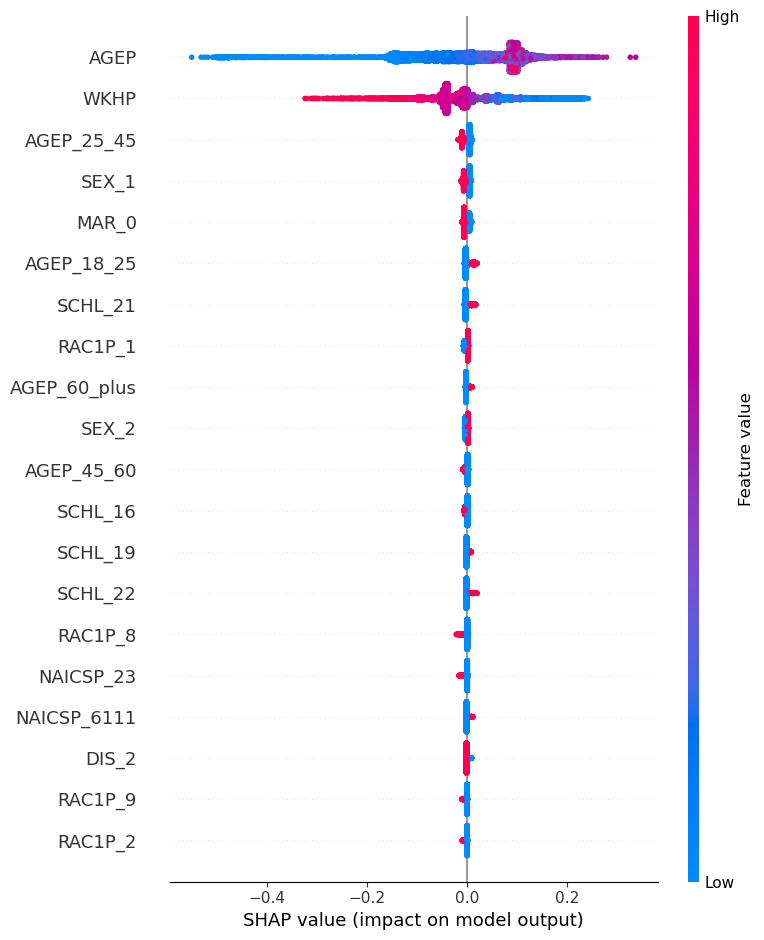

In [183]:
# sample representative background set and sample size
background_size = 5000
test_sample_size = 10000
 
# stratified sample from training set
sss_train = StratifiedShuffleSplit(n_splits=1, test_size=background_size, random_state=42)
_ , background_idx = next(sss_train.split(X_train_health, y_train_health))
 
# stratified sample from test set
X_test_array = X_test_health.toarray() if hasattr(X_test_health, "toarray") else X_test_health
sss_test = StratifiedShuffleSplit(n_splits=1, test_size=test_sample_size, random_state=42)
_, test_sample_idx_health = next(sss_test.split(X_test_array, y_test_health))
X_test_sample_health = X_test_array[test_sample_idx_health]
 
# set background
background = X_train_health[background_idx]
background = background.toarray() if hasattr(background, "toarray") else background
 
# DeepSHAP
explainer_health_NN = shap.DeepExplainer(ffnn_model_health, background)
deep_shap_values_health = explainer_health_NN.shap_values(X_test_sample_health).squeeze(-1)
 
shap.summary_plot(deep_shap_values_health, X_test_sample_health, feature_names=all_feature_names_health, max_display=20)


C:\Users\odiee\AppData\Local\Temp\ipykernel_14980\3746504667.py:47: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(deep_shap_values_health, X_test_health_df, max_display=20)


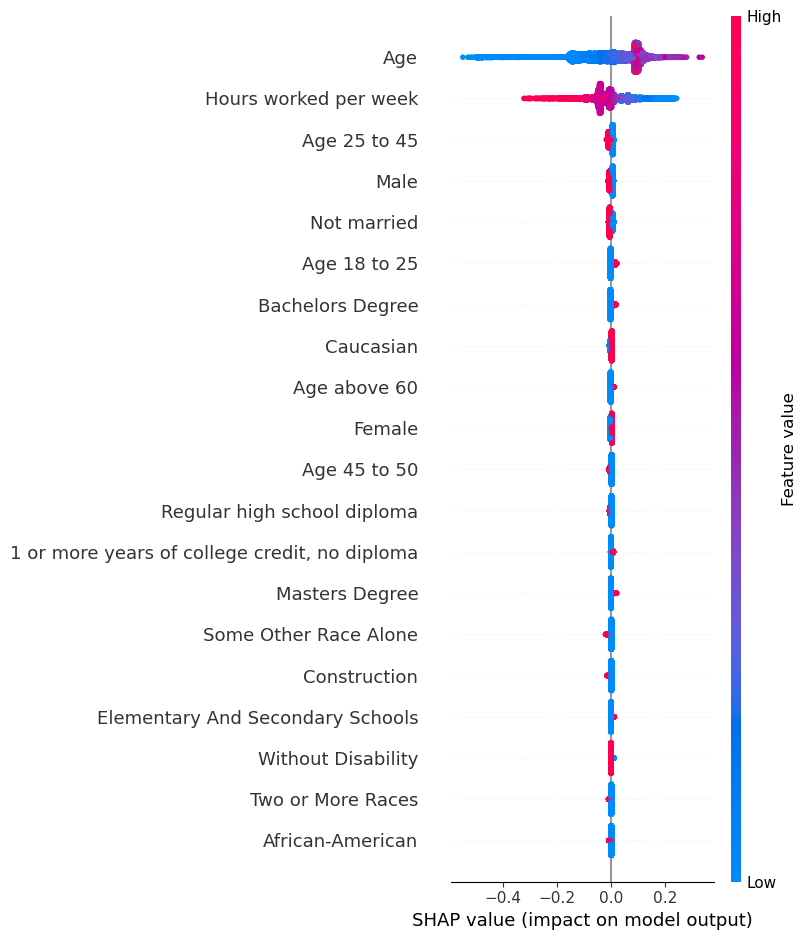

In [188]:
custom_names = {
    'PINCP': 'Income',
    'WKHP': 'Hours worked per week',
    'AGEP': 'Age',
    'SEX_1': 'Male',
    'SEX_2': 'Female',
    'SCHL_21': 'Bachelors Degree',
    'SCHL_16':'Regular high school diploma',
    'SCHL_23':'Professional degree beyond a bachelor\'s degree',
    'DIS_1': 'With Disability',
    'SCHL_22': 'Masters Degree',
    'NAICSP_23': 'Construction',
    'PINCP': 'Income',
    'WKHP': 'Hours worked per week',
    'AGEP_25_45': 'Age 25 to 45',
    'AGEP_18_25': 'Age 18 to 25',
    'AGEP_60_plus': 'Age above 60',
    'MAR_1': 'Married', 
    'SCHL_21': 'Bachelors Degree',
    'SCHL_16':'Regular high school diploma',
    'SCHL_23':'Professional degree beyond a bachelor\'s degree',
    'DIS_1': 'With Disability',
    'SCHL_22': 'Masters Degree',
    'MAR_0': 'Not married',
    'RAC1P_1': 'Caucasian',
    'NAICSP_722Z': 'Food Services And Drinking Places, Except Alcoholic Drinks',
    'DIS_2': 'Without Disability',
    'RAC1P_2': 'African-American',
    'SCHL_24': 'Doctorate Degree',
    'NAICSP_622M': 'General Medical And Surgical Hospitals',
    'NAICSP_6111': 'Elementary And Secondary Schools',
    'NAICSP_5415': 'Computer Systems Design and Related Services',
    'AGEP_45_60': 'Age 45 to 50',
    'RAC1P_8': 'Some Other Race Alone',
    'RAC1P_9': 'Two or More Races',
    'SCHL_18':'Some College, Less Than One Year',
    'SCHL_19':'1 or more years of college credit, no diploma',
    'SCHL_20':'Associate\'s Degree'
}


# Map custom names to all features
renamed_features_health = [custom_names.get(name, name) for name in all_feature_names_health[:305]]

# Convert input data to a DataFrame with renamed columns
X_test_health_df = pd.DataFrame(X_test_sample_health, columns=renamed_features_health)
shap.summary_plot(deep_shap_values_health, X_test_health_df, max_display=20)


In [187]:
# locally saving shap values
np.save("deepshap_values_health.npy", deep_shap_values_health
        )

with open("deepshap_values_health.pkl", "wb") as f:
    pickle.dump(deep_shap_values_health, f)


joblib.dump(deep_shap_values_health, "deepshap_explainer_health.joblib")

['deepshap_explainer_health.joblib']

In [189]:
# Save test input
df_x_test_sample = pd.DataFrame(X_test_sample_health, columns=all_feature_names_health[:305])
df_x_test_sample.to_csv('X_test_sample_health.csv', index=False)


# Statistics

## DeepSHAP statistics

In [40]:
shap_values_dp_income = np.load("deepshap_values_income.npy")

In [33]:
with open("deepshap_values_income.pkl", "rb") as f:
    dp_income_exp = pickle.load(f)

In [126]:
filter_names = ['NAICSP', 'SCHL']

In [ ]:
shap_values_dp_health = np.load("deepshap_values_health.npy")

In [125]:
X_test_sample_income_raw = X_test_inc.iloc[test_sample_idx_income]
print(X_test_sample_income_raw)


        RAC1P  SEX  MAR  DIS NAICSP  SCHL     AGEP  WKHP
133579      6    1    1    2   5411    23  60_plus    40
271700      1    1    1    2   92MP    24    45_60    50
94425       1    1    1    2     23    16    45_60    50
266706      1    2    1    2   92MP    16    25_45    40
79060       9    1    1    2  56173    11    45_60    40
...       ...  ...  ...  ...    ...   ...      ...   ...
472883      9    1    0    2   713Z    16    25_45    50
224293      1    2    1    2   622M    20    45_60    25
116234      1    1    0    2   92MP    22    25_45    40
48748       1    2    1    2   6111    24    45_60    50
417403      6    1    1    2   4231    20    25_45     0

[10000 rows x 8 columns]


In [143]:
selected_indices_income = [i for i, name in enumerate(X_test_sample_income_raw.columns) if name in filter_names]
shap_values_dp_income = deep_shap_values_income[:, selected_indices_income]
filtered_feature_names_income = X_test_sample_income_raw.columns[selected_indices_income]

In [190]:
X_test_sample_health_raw = X_test_h.iloc[test_sample_idx_health]
print(X_test_sample_health_raw)

        RAC1P  SEX  MAR  DIS  NAICSP  SCHL     AGEP   PINCP  WKHP
397710      6    2    1    2    622M    21  60_plus   60000    40
219232      1    2    0    1   44511    18  60_plus   11000     0
150967      1    2    1    2    4599    21    45_60    7500    10
354309      1    1    0    2    5413    21    25_45  105000    50
301601      1    2    0    2  812112    19    25_45   10000    20
...       ...  ...  ...  ...     ...   ...      ...     ...   ...
331478      1    2    1    2   2211P    22    45_60  123000    45
81116       1    2    0    2    5241    20    25_45   41000    45
230162      8    1    1    2    4244    14    45_60   61200    40
105019      1    1    1    2    622M    23    25_45  636000    60
10813       2    2    1    2    6241    21    45_60   52000    35

[10000 rows x 9 columns]


In [194]:
selected_indices_health = [i for i, name in enumerate(X_test_sample_health_raw.columns) if name in filter_names]
shap_values_dp_health = deep_shap_values_health[:, selected_indices_health]
filtered_feature_names_health = X_test_sample_health_raw.columns[selected_indices_health]

### Labelling

In [42]:
data = """
211: EXT-Oil And Gas Extraction
2121: EXT-Coal Mining
2122: EXT-Metal Ore Mining
2123: EXT-Nonmetallic Mineral Mining And Quarrying
213: EXT-Support Activities For Mining
2211P: UTL-Electric Power Generation, Transmission And Distribution
2212P: UTL-Natural Gas Distribution
22132: UTL-Sewage Treatment Facilities
2213M: UTL-Water Supply And Irrigation Systems, And Steam And Air-Conditioning Supply
221MP: UTL-Electric And Gas, And Other Combinations
22S: UTL-Not Specified Utilities
23: CON-Construction (The Cleaning Of Buildings And Dwellings Is Incidental During Construction And Immediately After Construction)
3113: MFG-Sugar And Confectionery Products
3114: MFG-Fruit And Vegetable Preserving And Specialty Food Manufacturing
3115: MFG-Dairy Product Manufacturing
3116: MFG-Animal Slaughtering And Processing
311811: MFG-Retail Bakeries
3118Z: MFG-Bakeries And Tortilla Manufacturing, Except Retail Bakeries
311M1: MFG-Animal Food, Grain And Oilseed Milling
311M2: MFG-Seafood And Other Miscellaneous Foods, N.E.C.
311S: MFG-Not Specified Food Industries
3121: MFG-Beverage Manufacturing
3122: MFG-Tobacco Manufacturing
3131: MFG-Fiber, Yarn, And Thread Mills
3132Z: MFG-Fabric Mills, Except Knit Fabric Mills
3133: MFG-Textile And Fabric Finishing And Fabric Coating Mills
31411: MFG-Carpet And Rug Mills
314Z: MFG-Textile Product Mills, Except Carpet And Rug
315M: MFG-Cut And Sew, And Apparel Accessories And Other Apparel Manufacturing
3162: MFG-Footwear Manufacturing
316M: MFG-Leather And Hide Tanning And Finishing, And Other Leather And Allied Product Manufacturing
31M: MFG-Knit Fabric Mills, And Apparel Knitting Mills
3211: MFG-Sawmills And Wood Preservation
3212: MFG-Veneer, Plywood, And Engineered Wood Product Manufacturing
32199M: MFG-Manufactured Home (Mobile Home) And Prefabricated Wood Building Manufacturing
3219ZM: MFG-Miscellaneous Wood Product Manufacturing
3221: MFG-Pulp, Paper, And Paperboard Mills
32221: MFG-Paperboard Container Manufacturing
3222M: MFG-Miscellaneous Paper And Pulp Products Manufacturing
3231: MFG-Printing And Related Support Activities
32411: MFG-Petroleum Refineries
3241M: MFG-Petroleum And Coal Products Manufacturing, Except Petroleum Refineries
3252: MFG-Resin, Synthetic Rubber, And Artificial And Synthetic Fibers And Filaments Manufacturing
3253: MFG-Pesticide, Fertilizer, And Other Agricultural Chemical Manufacturing
3254: MFG-Pharmaceutical And Medicine Manufacturing
3255: MFG-Paint, Coating, And Adhesive Manufacturing
3256: MFG-Soap, Cleaning Compound, And Toilet Preparation Manufacturing
325M: MFG-Basic Chemical Manufacturing, And Other Chemical Product And Preparation Manufacturing
3261: MFG-Plastics Product Manufacturing
32621: MFG-Tire Manufacturing
3262M: MFG-Rubber Products, Except Tires, Manufacturing
32711: MFG-Pottery, Ceramics, And Plumbing Fixture Manufacturing
32712: MFG-Clay Building Material And Refractories Manufacturing
3272: MFG-Glass And Glass Product Manufacturing
3279: MFG-Other Nonmetallic Mineral Product Manufacturing
327M: MFG-Cement, Concrete, Lime, And Gypsum Product Manufacturing
3313: MFG-Alumina And Aluminum Production And Processing
3314: MFG-Nonferrous Metal (Except Aluminum) Production And Processing
3315: MFG-Foundries
331M: MFG-Iron And Steel Mills And Steel Product Manufacturing
3321: MFG-Forging And Stamping
3322: MFG-Cutlery And Handtool Manufacturing
3327: MFG-Machine Shops; Turned Product; Screw, Nut, And Bolt Manufacturing
3328: MFG-Coating, Engraving, Heat Treating, And Allied Activities
33299M: MFG-Ordnance
332M: MFG-Architectural And Structural Metals, And Boiler, Tank, And Shipping Container Manufacturing
332MZ: MFG-Miscellaneous Fabricated Metal Product Manufacturing
33311: MFG-Agricultural Implement Manufacturing
3331M: MFG-Construction, And Mining And Oil And Gas Field Machinery Manufacturing
3333: MFG-Commercial And Service Industry Machinery Manufacturing
3335: MFG-Metalworking Machinery Manufacturing
3336: MFG-Engine, Turbine, And Power Transmission Equipment Manufacturing
333MS: MFG-Machinery Manufacturing, N.E.C. Or Not Specified
3341: MFG-Computer And Peripheral Equipment Manufacturing
3345: MFG-Navigational, Measuring, Electromedical, And Control Instruments Manufacturing
334M1: MFG-Communications, Audio, And Video Equipment Manufacturing
334M2: MFG-Semiconductor, Magnetic And Optical Media, And Other Electronic Component Manufacturing
3352: MFG-Household Appliance Manufacturing
335M: MFG-Electric Lighting And Electrical Equipment Manufacturing, And Other Electrical Component Manufacturing, N.E.C.
33641M1: MFG-Aircraft, Aircraft Engine, And Aircraft Parts Manufacturing
33641M2: MFG-Guided Missile And Space Vehicle And Parts Manufacturing
3365: MFG-Railroad Rolling Stock Manufacturing
3366: MFG-Ship And Boat Building
3369: MFG-Other Transportation Equipment Manufacturing
336M: MFG-Motor Vehicles And Motor Vehicle Equipment Manufacturing
337: MFG-Furniture And Related Product Manufacturing
3391: MFG-Medical Equipment And Supplies Manufacturing
3399M: MFG-Sporting And Athletic Goods, And Doll, Toy And Game Manufacturing
3399ZM: MFG-Miscellaneous Manufacturing, N.E.C.
33MS: MFG-Not Specified Metal Industries
3MS: MFG-Not Specified Manufacturing Industries
4231: WHL-Motor Vehicle And Motor Vehicle Parts And Supplies Merchant Wholesalers
4232: WHL-Furniture And Home Furnishing Merchant Wholesalers
4233: WHL-Lumber And Other Construction Materials Merchant Wholesalers
4234: WHL-Professional And Commercial Equipment And Supplies Merchant Wholesalers
4235: WHL-Metal and Mineral, Except Petroleum, Merchant Wholesalers
4236: WHL-Household Appliances And Electrical And Electronic Goods Merchant Wholesalers
4237: WHL-Hardware, And Plumbing And Heating Equipment, And Supplies Merchant Wholesalers
4238: WHL-Machinery, Equipment, And Supplies Merchant Wholesalers
42393: WHL-Recyclable Material Merchant Wholesalers
4239Z: WHL-Miscellaneous Durable Goods, Except Recyclable Material, Merchant Wholesalers
4241: WHL-Paper and Paper Product Merchant Wholesalers
4243: WHL-Apparel, Piece Goods, And Notions Merchant Wholesalers
4244: WHL-Grocery And Related Product Merchant Wholesalers
4245: WHL-Farm Product Raw Material Merchant Wholesalers
4247: WHL-Petroleum And Petroleum Products Merchant Wholesalers
4248: WHL-Beer, Wine, And Distilled Alcoholic Beverage Merchant Wholesalers
42491: WHL-Farm Supplies Merchant Wholesalers
4249Z: WHL-Miscellaneous Nondurable Goods Merchant, Except Farm Supplies, Wholesalers
424M: WHL-Drugs, Druggists' Sundries, And Chemical And Allied Products Merchant Wholesalers
4251: WHL-Wholesale Trade Agents And Brokers
42S: WHL-Not Specified Wholesale Trade
4411: RET-Automobile Dealers
4412: RET-Other Motor Vehicle Dealers
4413: RET-Automotive Parts, Accessories, And Tire Retailers
44414: RET-Hardware Retailers
4441Z: RET-Building Material And Supplies Dealers, Except Hardware Retailers
4442: RET-Lawn And Garden Equipment And Supplies Retailers
44511: RET-Supermarkets And Other Grocery (Except Convenience) Retailers
44513: RET-Convenience Retailers And Vending Machine Operators
4452: RET-Specialty Food Retailers
4453: RET-Beer, Wine, And Liquor Retailers
4491: RET-Furniture And Home Furnishings Retailers
4492: RET-Electronics And Appliance Retailers
4551: RET-Department Stores
4552: RET-Warehouse Clubs, Supercenters, And Other General Merchandise Retailers
45611: RET-Pharmacies And Drug Retailers
4561Z: RET-Health And Personal Care, Except Pharmacies And Drug, Retailers
4571: RET-Gasoline Stations
4572: RET-Fuel Dealers
4581: RET-Clothing And Clothing Accessories Retailers
4582: RET-Shoe Retailers
4583: RET-Jewelry, Luggage, And Leather Goods Retailers
45913: RET-Sewing, Needlework, And Piece Goods Retailers
45914: RET-Musical Instrument And Supplies Retailers
4591M: RET-Sporting Goods, And Hobby, Toy, And Game Retailers
45921: RET-Book Retailers And News Dealers
4593: RET-Florists
45941: RET-Office Supplies And Stationery Retailers
45942: RET-Gift, Novelty, And Souvenir Retailers
4595: RET-Used Merchandise Retailers
4599: RET-Other Miscellaneous Retailers
481: TRN-Air Transportation
482: TRN-Rail Transportation
483: TRN-Water Transportation
484: TRN-Truck Transportation
4853: TRN-Taxi And Limousine Service
485M: TRN-Transit And Ground Passenger Transportation, Except Taxi And Limousine Service
486: TRN-Pipeline Transportation
487: TRN-Scenic And Sightseeing Transportation
488: TRN-Support Activities For Transportation
491: TRN-Postal Service
492: TRN-Couriers And Messengers
493: TRN-Warehousing And Storage
4MS: RET-Not Specified Retail Trade
5121: INF-Motion Pictures And Video Industries
5122: INF-Sound Recording Industries
51311: INF-Newspaper Publishers
5131Z: INF-Periodical, Book, And Directory And Mailing List, And Other Publishers
5132: INF-Software Publishers
516: INF-Broadcasting and content providers
517111: INF-Wired Telecommunications Carriers
517Z: INF-Telecommunications, Except Wired Telecommunications Carriers
5182: INF-Computing Infrastructure Providers, Data Processing, Web Hosting, And Related Services
51921: INF-Libraries And Archives
51929: INF-Web Search Portals And All Other Information Services
5221M: FIN-Credit Unions, And Savings Institutions And Other Depository Credit Intermediation
522M: FIN-Nondepository Credit Intermediation And Related Activities
5241: FIN-Insurance Carriers
5242: FIN-Agencies, Brokerages, And Other Insurance Related Activities
52M1: FIN-Monetary Authorities-Central Bank, And Commercial Banking
52M2: FIN-Securities, Commodities, Funds, Trusts, And Other Financial Investments
5313: FIN-Activities Related To Real Estate
531M: FIN-Lessors Of Real Estate, And Offices Of Real Estate Agents And Brokers
5321: FIN-Automotive Equipment Rental And Leasing
532M2: FIN-Consumer Goods Rental, And General Rental Centers
53M: FIN-Commercial And Industrial Machinery And Equipment, And Nonfinancial Intangible Assets Rental And Leasing
5411: PRF-Legal Services
5412: PRF-Accounting, Tax Preparation, Bookkeeping, And Payroll Services
5413: PRF-Architectural, Engineering, And Related Services
5414: PRF-Specialized Design Services
5415: PRF-Computer Systems Design And Related Services
5416: PRF-Management, Scientific, And Technical Consulting Services
5417: PRF-Scientific Research And Development Services
5418: PRF-Advertising, Public Relations, And Related Services
54194: PRF-Veterinary Services
5419Z: PRF-Other Professional, Scientific, And Technical, Except Veterinary, Services
55: PRF-Management Of Companies And Enterprises
5613: PRF-Employment Services
5614: PRF-Business Support Services
5615: PRF-Travel Arrangements And Reservation Services
5616: PRF-Investigation And Security Services
56173: PRF-Landscaping Services
5617Z: PRF-Services To Buildings And Dwellings, Except Landscaping Services
561M: PRF-Other Administrative And Other Support Services
562: PRF-Waste Management And Remediation Services
6111: EDU-Elementary And Secondary Schools
611M1: EDU-Junior Colleges, Colleges, Universities, And Professional Schools
611M2: EDU-Business, Trade And Technical Schools, And Computer And Management Training
611M3: EDU-Other Schools And Instruction, And Educational Support Services
6211: MED-Offices Of Physicians
6212: MED-Offices Of Dentists
62131: MED-Offices Of Chiropractors
62132: MED-Offices Of Optometrists
6213ZM: MED-Offices Of Other Health Practitioners
6214: MED-Outpatient Care Centers
6216: MED-Home Health Care Services
621M: MED-Other Health Care Services
6222: MED-Psychiatric And Substance Abuse Hospitals
622M: MED-General Medical And Surgical Hospitals, And Specialty (Except Psychiatric And Substance Abuse) Hospitals
6231: MED-Nursing Care Facilities (Skilled Nursing Facilities)
623M: MED-Residential Care Facilities, Except Skilled Nursing Facilities
6241: SCA-Individual And Family Services
6242: SCA-Community Food And Housing, And Emergency And Other Relief Services
6243: SCA-Vocational Rehabilitation Services
6244: SCA-Child Care Services
7111: ENT-Performing Arts Companies
7112: ENT-Spectator Sports
7115: ENT-Independent Artists, Writers, And Performers
711M: ENT-Promoters Of Performing Arts, Sports, And Similar Events, Agents And Managers For Artists, Athletes, Entertainers, And Other Public Figures
712: ENT-Museums, Historical Sites, And Similar Institutions
71395: ENT-Bowling Centers
713Z: ENT-Other Amusement, Gambling, And Recreation Industries
7211: ENT-Traveler Accommodation
721M: ENT-Recreational Vehicle Parks And Camps, And Rooming And Boarding Houses, Dormitories, And Workers' Camps
7224: ENT-Drinking Places (Alcoholic Beverages)
722Z: ENT-Food Services And Drinking Places, Except Alcoholic Beverages
811192: SRV-Car Washes
8111Z: SRV-Automotive Repair And Maintenance, Except Car Washes
8112: SRV-Electronic And Precision Equipment Repair And Maintenance
8113: SRV-Commercial And Industrial Machinery And Equipment Repair And Maintenance
8114: SRV-Personal And Household Goods Repair And Maintenance
812111: SRV-Barber Shops
812112: SRV-Beauty Salons
8121M: SRV-Nail Salons And Other Personal Care Services
8122: SRV-Death Care Services
8123: SRV-Drycleaning And Laundry Services
8129: SRV-Other Personal Services
8131: SRV-Religious Organizations
81393: SRV-Labor Unions And Similar Labor Organizations
8139Z: SRV-Business, Professional, Political, And Similar Organizations
813M: SRV-Civic, Social, Advocacy Organizations, And Grantmaking And Giving Services
814: SRV-Private Households
92113: ADM-Public Finance Activities
92119: ADM-Other General Government And Support
9211MP: ADM-Executive Offices And Legislative Bodies
923: ADM-Administration Of Human Resource Programs
92811P1: MIL-U.S. Army
92811P2: MIL-U.S. Air Force
92811P3: MIL-U.S. Navy
92811P4: MIL-U.S. Marines
92811P5: MIL-U.S. Coast Guard
92811P6: MIL-Armed Forces, Branch Not Specified
92811P7: MIL-Military Reserves Or National Guard
9281P: ADM-National Security And International Affairs
92M1: ADM-Administration Of Environmental Quality, And Housing Programs, Urban Planning And Community Development
92M2: ADM-Administration Of Economic Programs And Space Research And Technology
92MP: ADM-Justice, Public Order, And Safety Activities

"""

# Parse and build the dictionary
naics_dict = {}

for line in data.strip().split('\n'):
    # Split at the first colon ':'
    code, description = line.split(':', 1)
    code = code.strip()
    description = description.strip()

    # Compose the key with "NAICSP_" prefix
    key = f"NAICSP_{code}"

    # Store in dict
    naics_dict[key] = description

# Example output
for k, v in list(naics_dict.items())[:5]:  # show first 5 entries
    print(f'{k}: "{v}"')


NAICSP_211: "EXT-Oil And Gas Extraction"
NAICSP_2121: "EXT-Coal Mining"
NAICSP_2122: "EXT-Metal Ore Mining"
NAICSP_2123: "EXT-Nonmetallic Mineral Mining And Quarrying"
NAICSP_213: "EXT-Support Activities For Mining"


In [43]:
SCHL = {1:"No schooling completed",
2:"Nursery school or preschool",
3:"Kindergarten",
4:"Grade 1",
5:"Grade 2",
6:"Grade 3",
7:"Grade 4",
8:"Grade 5",
9:"Grade 6",
10:"Grade 7",
11:"Grade 8",
12:"Grade 9",
13:"Grade 10",
14:"Grade 11",
15:"Grade 12 (no diploma)",
16:"Regular high school diploma",
17:"GED or alternative credential",
18:"Some college but less than 1 year",
19:"1 or more years of college credit but no degree",
20:"Associate’s degree",
21:"Bachelor’s degree",
22:"Master’s degree",
23:"Professional degree beyond a bachelor’s degree",
24:"Doctorate degree"}
MAR = {1:"Married", 2:"Widowed", 3:"Divorced",4:"Separated",5:"Never married or under 15 years old"}
RELP = {0:"Reference person",
1:"Husband or wife",
2:"Biological son or daughter",
3:"Adopted son or daughter",
4:"Stepson or stepdaughter",
5:"Brother or sister",
6:"Father or mother",
7:"Grandchild",
8:"Parent-in-law",
9:"Son-in-law or daughter-in-law",
10:"Other relative",
11:"Roomer or boarder",
12:"Housemate or roommate",
13:"Unmarried partner",
14:"Foster child",
15:"Other nonrelative",
16:"Institutionalized group quarters population. Includes correctional facilities, nursing homes, and mental hospitals.",
17:"Noninstitutionalized group quarters population. Includes college dormitories, military barracks, group homes, missions, and shelters."}
SEX = {1:"Male", 2:"Female"}
RAC1P = {1:"White alone",
2:"Black or African American alone",
3:"American Indian alone",
4:"Alaska Native alone",
5:"American Indian and Alaska native tribes specified; or American Indian or Alaska Native, not specified and no other races",
6:"Asian alone",
7:"Native Hawaiian and Other Pacific Islander alone",
8:"Some Other Race alone",
9:"Two or More races"}
AGEP = {
    '18_25': 'Age 18–25',
    '25_45': 'Age 25–45',
    '45_60': 'Age 45–60',
    '60_plus': 'Age 60+'
}
DIS = {1: "With disability", 2: "Without disability"}
NAICS = naics_dict

### Non-parametric assumptions

In [144]:
def cohend(d1, d2):
    d1 = np.array(d1)
    d2 = np.array(d2)

    # Remove NaNs
    d1 = d1[~np.isnan(d1)]
    d2 = d2[~np.isnan(d2)]

    if len(d1) < 2 or len(d2) < 2:
        return np.nan

    s1 = np.var(d1, ddof=1)
    s2 = np.var(d2, ddof=1)
    s = np.sqrt(((len(d1) - 1)*s1 + (len(d2) - 1)*s2) / (len(d1) + len(d2) - 2))

    if s == 0 or np.isnan(s):
        return np.nan

    return (np.mean(d1) - np.mean(d2)) / s


In [145]:
## Function to generate subgroups by taking all combinations of two features (e.g. sex and race)
def extract_subgroups(df, attr1, attr2):
    attr_values = {
        'SEX': [1, 2],
        'RAC1P': [1, 2, 6, 8, 9], # to-do: limit number of races
        'MAR': [0, 1],  # to-do: binarise
        'AGEP': ['18_25', '25_45', '45_60', '60_plus'],
        'DIS': [1,2]
    }
    subgroups = {}

    for val1 in attr_values[attr1]:
        for val2 in attr_values[attr2]:
            subgroup_name = f"{attr1}_{val1}_{attr2}_{val2}"
            mask = (df[attr1] == val1) & (df[attr2] == val2)
            subgroups[subgroup_name] = mask.values 
  

    return subgroups

In [146]:

def cliffs_delta(x, y):
    """
    Efficient Cliff's Delta using NumPy broadcasting.
    Returns: delta (float), with sign
    """
    x = np.asarray(x)
    y = np.asarray(y)

    nx = len(x)
    ny = len(y)

    if nx == 0 or ny == 0:
        return np.nan

    # Compare all pairs
    diff = x[:, None] - y
    n_greater = np.sum(diff > 0)
    n_less = np.sum(diff < 0)

    delta = (n_greater - n_less) / (nx * ny)
    return delta


In [196]:
def t_test_all_subgroups(df, shap_values, attr1, attr2, feature_names):
    subgroup_masks = extract_subgroups(df, attr1, attr2)
    t_test_results = []

    for (name1, mask1), (name2, mask2) in itertools.combinations(subgroup_masks.items(), 2):
        #shap1 = preprocessing.normalize(shap_values[mask1], norm='l2', axis=1)
        #shap2 = preprocessing.normalize(shap_values[mask2], norm='l2', axis=1)
        shap1 = shap_values[mask1]
        shap2 = shap_values[mask2]
        if shap1.shape[0] == 0 or shap2.shape[0] == 0:
            continue
        for i, feature in enumerate(feature_names):
            group1 = shap1[:, i]
            group2 = shap2[:, i]
            stat_ks, p_ks = ks_2samp(group1,group2)

            stat_u, p_mwu = mannwhitneyu(group1, group2, alternative='two-sided')
            effect_size = cliffs_delta(group1, group2)
            if np.isnan(effect_size):
                continue

            mean_diff = group1.mean() - group2.mean()
            full_feature = feature

            try:
                parts = feature.split('_')
                if parts[0] == 'AGEP':
                    category_name = '_'.join(parts[1:])
                    full_feature = AGEP.get(category_name, feature)
                else:
                    target = parts[0]
                    index = int(float(parts[1]))
                    full_feature = (
                        SCHL[index] if target == 'SCHL' else
                        MAR[index] if target == 'MAR' else
                        RELP[index] if target == 'RELP' else
                        SEX[index] if target == 'SEX' else
                        RAC1P[index] if target == 'RAC1P' else
                        DIS[index] if target == 'DIS' else
                        naics_dict[index] if target == 'NAICSP' else
                        feature
                    )
            except:
                if feature == 'WKHP':
                    full_feature = "working hours per week"

            t_test_results.append({
                'subgroup1': name1,
                'subgroup2': name2,
                'feature': feature,
                'feature description': full_feature,
                'ks_p': p_ks,
                'u-test statistic': stat_u,
                'mwu_p': p_mwu,
                'effect_size': effect_size,
                'mean_diff': mean_diff
            })

    return pd.DataFrame(t_test_results)


In [207]:
attr_combinations = [
    ('RAC1P', 'SEX'),
    ('AGEP', 'SEX'),
    ('MAR', 'SEX'),
    ('DIS', 'SEX'),
    ('DIS', 'RAC1P')
]

shap_sets = {
    'health': {
        'shap': shap_values_dp_health,
        'features': filtered_feature_names_health,
       'X': X_test_sample_health_raw
   }

   # 'income': {
   #     'shap': shap_values_dp_income,
   #     'features': filtered_feature_names_income,
   #     'X': X_test_sample_income_raw
   
    # }

}

results_dict = {}

for shap_label, dataset in shap_sets.items():
    print(f"\n\n================== SHAP Target: {shap_label.upper()} ==================")

    shap_values = dataset['shap']
    feature_names = dataset['features']
    X_test = dataset['X']

    for attr1, attr2 in attr_combinations:
        print(f"\n---- Analyzing Subgroups: {attr1} x {attr2} ----")

        try:
            df_result = t_test_all_subgroups(X_test, shap_values, attr1=attr1, attr2=attr2, feature_names=feature_names)
            df_result['attr1'] = attr1
            df_result['attr2'] = attr2
            df_result['target'] = shap_label

            result_key = f"{shap_label}_{attr1.lower()}_{attr2.lower()}"
            results_dict[result_key] = df_result

            # Show top significant effects
            significant_results = df_result[(df_result['ks_p'] < 0.05) & (df_result['mwu_p'] < 0.05) &                # Statistically significant shift
            (df_result['effect_size'] >= 0.33) | (df_result['effect_size'] <= -0.33) # moderate or large Cliff's delta
]

            significant_results = significant_results.sort_values(by='effect_size', ascending=False)

            if significant_results.empty:
                print("No significant results (KS similar, MWU p < 0.05, |effect size| > 0.5)")
            else:
                print(significant_results[['feature description', 'subgroup1', 'subgroup2', 'effect_size', 'ks_p', 'mwu_p']].head(20))

        except KeyError as e:
            print(f"Skipped due to missing column: {e}")
        except Exception as e:
            print(f"Error processing {attr1} x {attr2}: {e}")




================== SHAP Target: HEALTH ==================

---- Analyzing Subgroups: RAC1P x SEX ----
No significant results (KS similar, MWU p < 0.05, |effect size| > 0.5)

---- Analyzing Subgroups: AGEP x SEX ----
   feature description         subgroup1           subgroup2  effect_size  \
22              NAICSP  AGEP_18_25_SEX_2  AGEP_60_plus_SEX_1     0.562022   
24              NAICSP  AGEP_18_25_SEX_2  AGEP_60_plus_SEX_2     0.521706   
10              NAICSP  AGEP_18_25_SEX_1  AGEP_60_plus_SEX_1     0.494587   
12              NAICSP  AGEP_18_25_SEX_1  AGEP_60_plus_SEX_2     0.458814   
18              NAICSP  AGEP_18_25_SEX_2    AGEP_45_60_SEX_1     0.427024   
40              NAICSP  AGEP_25_45_SEX_2  AGEP_60_plus_SEX_1     0.424346   
42              NAICSP  AGEP_25_45_SEX_2  AGEP_60_plus_SEX_2     0.360271   
14              NAICSP  AGEP_18_25_SEX_2    AGEP_25_45_SEX_1     0.351084   
6               NAICSP  AGEP_18_25_SEX_1    AGEP_45_60_SEX_1     0.340030   
7           

In [198]:
import os
output_dir = "effect_size_dp_health"
os.makedirs(output_dir, exist_ok=True)

for name, df in results_dict.items():
    df.to_csv(os.path.join(output_dir, f"{name}.csv"), index=False)


## TreeSHAP statistics

In [89]:
shap_values_tp_health = np.load("treeshap_values_health.npy")
shap_values_tp_income = np.load("treeshap_values_income.npy")

In [90]:
with open("treeshap_values_income.pkl", "rb") as f:
    tp_income_exp = pickle.load(f)

In [95]:
filter_names = ['NAICSP_111', 'NAICSP_112', 'NAICSP_1133', 'NAICSP_113M', 'NAICSP_114', 'NAICSP_115', 'NAICSP_211', 'NAICSP_2121', 'NAICSP_2122', 'NAICSP_2123', 'NAICSP_213', 'NAICSP_2211P', 'NAICSP_2212P', 'NAICSP_22132', 'NAICSP_2213M', 'NAICSP_221MP', 'NAICSP_22S', 'NAICSP_23', 'NAICSP_3113', 'NAICSP_3114', 'NAICSP_3115', 'NAICSP_3116', 'NAICSP_311811', 'NAICSP_3118Z', 'NAICSP_311M1', 'NAICSP_311M2', 'NAICSP_311S', 'NAICSP_3121', 'NAICSP_3122', 'NAICSP_3131', 'NAICSP_3132Z', 'NAICSP_3133', 'NAICSP_31411', 'NAICSP_314Z', 'NAICSP_315M', 'NAICSP_3162', 'NAICSP_316M', 'NAICSP_31M', 'NAICSP_3211', 'NAICSP_3212', 'NAICSP_32199M', 'NAICSP_3219ZM', 'NAICSP_3221', 'NAICSP_32221', 'NAICSP_3222M', 'NAICSP_3231', 'NAICSP_32411', 'NAICSP_3241M', 'NAICSP_3252', 'NAICSP_3253', 'NAICSP_3254', 'NAICSP_3255', 'NAICSP_3256', 'NAICSP_325M', 'NAICSP_3261', 'NAICSP_32621', 'NAICSP_3262M', 'NAICSP_32711', 'NAICSP_32712', 'NAICSP_3272', 'NAICSP_3279', 'NAICSP_327M', 'NAICSP_3313', 'NAICSP_3314', 'NAICSP_3315', 'NAICSP_331M', 'NAICSP_3321', 'NAICSP_3322', 'NAICSP_3327', 'NAICSP_3328', 'NAICSP_33299M', 'NAICSP_332M', 'NAICSP_332MZ', 'NAICSP_33311', 'NAICSP_3331M', 'NAICSP_3333', 'NAICSP_3335', 'NAICSP_3336', 'NAICSP_333MS', 'NAICSP_3341', 'NAICSP_3345', 'NAICSP_334M1', 'NAICSP_334M2', 'NAICSP_3352', 'NAICSP_335M', 'NAICSP_33641M1', 'NAICSP_33641M2', 'NAICSP_3365', 'NAICSP_3366', 'NAICSP_3369', 'NAICSP_336M', 'NAICSP_337', 'NAICSP_3391', 'NAICSP_3399M', 'NAICSP_3399ZM', 'NAICSP_33MS', 'NAICSP_3MS', 'NAICSP_4231', 'NAICSP_4232', 'NAICSP_4233', 'NAICSP_4234', 'NAICSP_4235', 'NAICSP_4236', 'NAICSP_4237', 'NAICSP_4238', 'NAICSP_42393', 'NAICSP_4239Z', 'NAICSP_4241', 'NAICSP_4243', 'NAICSP_4244', 'NAICSP_4245', 'NAICSP_4247', 'NAICSP_4248', 'NAICSP_42491', 'NAICSP_4249Z', 'NAICSP_424M', 'NAICSP_4251', 'NAICSP_42S', 'NAICSP_4411', 'NAICSP_4412', 'NAICSP_4413', 'NAICSP_44414', 'NAICSP_4441Z', 'NAICSP_4442', 'NAICSP_44511', 'NAICSP_44513', 'NAICSP_4452', 'NAICSP_4453', 'NAICSP_4491', 'NAICSP_4492', 'NAICSP_4551', 'NAICSP_4552', 'NAICSP_45611', 'NAICSP_4561Z', 'NAICSP_4571', 'NAICSP_4572', 'NAICSP_4581', 'NAICSP_4582', 'NAICSP_4583', 'NAICSP_45913', 'NAICSP_45914', 'NAICSP_4591M', 'NAICSP_45921', 'NAICSP_4593', 'NAICSP_45941', 'NAICSP_45942', 'NAICSP_4595', 'NAICSP_4599', 'NAICSP_481', 'NAICSP_482', 'NAICSP_483', 'NAICSP_484', 'NAICSP_4853', 'NAICSP_485M', 'NAICSP_486', 'NAICSP_487', 'NAICSP_488', 'NAICSP_491', 'NAICSP_492', 'NAICSP_493', 'NAICSP_4MS', 'NAICSP_5121', 'NAICSP_5122', 'NAICSP_51311', 'NAICSP_5131Z', 'NAICSP_5132', 'NAICSP_516', 'NAICSP_517111', 'NAICSP_517Z', 'NAICSP_5182', 'NAICSP_51921', 'NAICSP_51929', 'NAICSP_5221M', 'NAICSP_522M', 'NAICSP_5241', 'NAICSP_5242', 'NAICSP_52M2', 'NAICSP_52M3', 'NAICSP_5313', 'NAICSP_531M', 'NAICSP_5321', 'NAICSP_532M2', 'NAICSP_53M', 'NAICSP_5411', 'NAICSP_5412', 'NAICSP_5413', 'NAICSP_5414', 'NAICSP_5415', 'NAICSP_5416', 'NAICSP_5417', 'NAICSP_5418', 'NAICSP_54194', 'NAICSP_5419Z', 'NAICSP_55', 'NAICSP_5613', 'NAICSP_5614', 'NAICSP_5615', 'NAICSP_5616', 'NAICSP_56173', 'NAICSP_5617Z', 'NAICSP_561M', 'NAICSP_562', 'NAICSP_6111', 'NAICSP_611M1', 'NAICSP_611M2', 'NAICSP_611M3', 'NAICSP_6211', 'NAICSP_6212', 'NAICSP_62131', 'NAICSP_62132', 'NAICSP_6213ZM', 'NAICSP_6214', 'NAICSP_6216', 'NAICSP_621M', 'NAICSP_6222', 'NAICSP_622M', 'NAICSP_6231', 'NAICSP_623M', 'NAICSP_6241', 'NAICSP_6242', 'NAICSP_6243', 'NAICSP_6244', 'NAICSP_7111', 'NAICSP_7112', 'NAICSP_7115', 'NAICSP_711M', 'NAICSP_712', 'NAICSP_71395', 'NAICSP_713Z', 'NAICSP_7211', 'NAICSP_721M', 'NAICSP_7224', 'NAICSP_722Z', 'NAICSP_811192', 'NAICSP_8111Z', 'NAICSP_8112', 'NAICSP_8113', 'NAICSP_8114', 'NAICSP_812111', 'NAICSP_812112', 'NAICSP_8121M', 'NAICSP_8122', 'NAICSP_8123', 'NAICSP_8129', 'NAICSP_8131', 'NAICSP_81393', 'NAICSP_8139Z', 'NAICSP_813M', 'NAICSP_814', 'NAICSP_92113', 'NAICSP_92119', 'NAICSP_9211MP', 'NAICSP_923', 'NAICSP_92811P1', 'NAICSP_92811P2', 'NAICSP_92811P3', 'NAICSP_92811P4', 'NAICSP_92811P5', 'NAICSP_92811P6', 'NAICSP_92811P7', 'NAICSP_9281P', 'NAICSP_92M1', 'NAICSP_92M2', 'NAICSP_92MP', 'SCHL_1', 'SCHL_2', 'SCHL_3', 'SCHL_4', 'SCHL_5', 'SCHL_6', 'SCHL_7', 'SCHL_8', 'SCHL_9', 'SCHL_10', 'SCHL_11', 'SCHL_12', 'SCHL_13', 'SCHL_14', 'SCHL_15', 'SCHL_16', 'SCHL_17', 'SCHL_18', 'SCHL_19', 'SCHL_20', 'SCHL_21', 'SCHL_22', 'SCHL_23', 'SCHL_24']

In [96]:
# Suppose you've now loaded feature_names
selected_indices = [i for i, name in enumerate(tp_income_exp.feature_names) if name in filter_names]
shap_values_tp_income = tp_income_exp.values[:, selected_indices]


In [97]:
with open("treeshap_values_health.pkl", "rb") as f:
    tp_health_exp = pickle.load(f)

In [98]:
selected_indices = [i for i, name in enumerate(tp_health_exp.feature_names) if name in filter_names]
shap_values_tp_health  = tp_health_exp.values[:, selected_indices]

In [49]:
income_df = sample = pd.read_csv("income_test_predictions_XGBoost.csv")
health_df = sample = pd.read_csv("health_test_predictions_XGBoost.csv")

### With parametric assumptions

In [ ]:
def t_test_all_subgroups(df, shap_values, attr1, attr2):

    subgroup_masks = extract_subgroups(df, attr1, attr2)
    t_test_results = []
    #print("SHAP shape:", shap_values.shape)
    feature_names = filter_names
     
   
    for (name1, mask1), (name2, mask2) in itertools.combinations(subgroup_masks.items(), 2):

 
        shap1 = preprocessing.normalize(shap_values[mask1], norm='l2', axis=1) 
        shap2 = preprocessing.normalize(shap_values[mask2], norm='l2', axis=1)

        # skip if there are no instances belonging to the subgroup
        if shap1.shape[0] == 0 or shap2.shape[0] == 0:
            continue

        for i, feature in enumerate(feature_names):
            group1 = shap1[:, i]
            group2 = shap2[:, i]
        
            stat_u, p_value = mannwhitneyu(group1, group2)
            effect_size = cohend(group1, group2)
            if np.isnan(effect_size):
                continue  # skip 

            mean_diff = group1.mean() - group2.mean()

            full_feature = feature
            
            try:
                parts = feature.split('_')
                if parts[0] == 'AGEP':
                    category_name = '_'.join(parts[1:])
                    full_feature = AGEP.get(category_name, feature)

                else: 
                    target = parts[0]
                    index = int(float(parts[1]))

                    full_feature = (
                        #COW[index] if target == 'COW' else
                        SCHL[index] if target == 'SCHL' else
                        MAR[index] if target == 'MAR' else
                        RELP[index] if target == 'RELP' else
                        SEX[index] if target == 'SEX' else
                        RAC1P[index] if target == 'RAC1P' else
                        DIS[index] if target == 'DIS' else
                        naics_dict[index] if target == 'NAICSP' else
                        feature
                    )
            except:
                if feature == 'WKHP':
                    full_feature = "working hours per week"

            t_test_results.append({
                'subgroup1': name1,
                'subgroup2': name2,
                'feature': feature,
                'feature description': full_feature,
                'u-test statistic': stat_u,
                'p_value': p_value,
                'effect_size': effect_size,
                'mean_diff': mean_diff
            })
            
    return pd.DataFrame(t_test_results)

In [64]:
attr_combinations = [
    ('RAC1P', 'SEX'),
    ('AGEP', 'SEX'),
    ('MAR', 'SEX'),
    ('DIS', 'SEX'),
    ('DIS', 'RAC1P')
]

shap_sets = {
    'health': shap_values_tp_health,
    'income': shap_values_tp_income
}

x_test_sets = {
    'health': X_test_h,
    'income': X_test_inc
}

results_dict = {}  # key: 'health_mar_sex', value: DataFrame

for shap_label, shap_values in shap_sets.items():
    print(f"\n\n================== SHAP Target: {shap_label.upper()} ==================")

    X_test = x_test_sets[shap_label]  

    for attr1, attr2 in attr_combinations:
        print(f"\n---- Analyzing Subgroups: {attr1} x {attr2} ----")

        try:
            df_result = t_test_all_subgroups(X_test, shap_values, attr1=attr1, attr2=attr2)
            df_result['attr1'] = attr1
            df_result['attr2'] = attr2
            df_result['target'] = shap_label

            # Save to dict with standardized name
            result_key = f"{shap_label}_{attr1.lower()}_{attr2.lower()}"
            results_dict[result_key] = df_result

            # Optional print significant results
            significant_results = df_result[df_result['effect_size'].abs() > 0.5]
            significant_results = significant_results.sort_values(by='effect_size', ascending=False)

            if significant_results.empty:
                print("No significant results (|Cohen's d| > 0.5)")
            else:
                print(significant_results[['feature description', 'subgroup1', 'subgroup2', 'effect_size', 'p_value']].head(20))

        except KeyError as e:
            print(f"Skipped due to missing column: {e}")
        except Exception as e:
            print(f"Error processing {attr1} x {attr2}: {e}")





================== SHAP Target: HEALTH ==================

---- Analyzing Subgroups: RAC1P x SEX ----
               feature description      subgroup1      subgroup2  effect_size  \
10731  Nursery school or preschool  RAC1P_6_SEX_2  RAC1P_9_SEX_1     2.108958   
6595                   NAICSP_3369  RAC1P_2_SEX_1  RAC1P_9_SEX_2     1.440123   
10300                  NAICSP_4251  RAC1P_6_SEX_2  RAC1P_8_SEX_2     1.299399   
6029                   NAICSP_3369  RAC1P_2_SEX_1  RAC1P_8_SEX_2     1.281819   
6799                   NAICSP_2121  RAC1P_2_SEX_2  RAC1P_6_SEX_1     1.037485   
8625                  NAICSP_45913  RAC1P_6_SEX_1  RAC1P_6_SEX_2     1.013311   
10866                  NAICSP_4251  RAC1P_6_SEX_2  RAC1P_9_SEX_2     0.953065   
6794                   NAICSP_1133  RAC1P_2_SEX_2  RAC1P_6_SEX_1     0.947116   
6538                   NAICSP_3133  RAC1P_2_SEX_1  RAC1P_9_SEX_2     0.939695   
9708                   NAICSP_3369  RAC1P_6_SEX_1  RAC1P_9_SEX_2     0.908476   
7365 

### Fully non-parametric

In [139]:
## Function to generate subgroups by taking all combinations of two features (e.g. sex and race)
def extract_subgroups(df, attr1, attr2):
    attr_values = {
        'SEX': [1, 2],
        'RAC1P': [1, 2, 6, 8, 9], # to-do: limit number of races
        'MAR': [0, 1],  # to-do: binarise
        'AGEP': ['18_25', '25_45', '45_60', '60_plus'],
        'DIS': [1,2]
    }
    subgroups = {}

    for val1 in attr_values[attr1]:
        for val2 in attr_values[attr2]:
            subgroup_name = f"{attr1}_{val1}_{attr2}_{val2}"
            mask = (df[attr1] == val1) & (df[attr2] == val2)
            subgroups[subgroup_name] = mask.values 
  

    return subgroups

def t_test_all_subgroups(df, shap_values, attr1, attr2):
    subgroup_masks = extract_subgroups(df, attr1, attr2)
    t_test_results = []

    for (name1, mask1), (name2, mask2) in itertools.combinations(subgroup_masks.items(), 2):
        #shap1 = preprocessing.normalize(shap_values[mask1], norm='l2', axis=1)
        #shap2 = preprocessing.normalize(shap_values[mask2], norm='l2', axis=1)
        shap1 = shap_values[mask1]
        shap2 = shap_values[mask2]
        if shap1.shape[0] == 0 or shap2.shape[0] == 0:
            continue

        for i, feature in enumerate(filter_names):
            group1 = shap1[:, i]
            group2 = shap2[:, i]

            #try:
            #    group1 = np.random.choice(group1, size=5000, replace=False)
            #    group2 = np.random.choice(group2, size=5000, replace=False)
            #except:
            #    pass # array is already less than 5000

            stat_ks, p_ks = ks_2samp(group1,group2)

            #shapiro_gr1 = shapiro(group1).pvalue
            #shapiro_gr2 = shapiro(group2).pvalue
            #if shapiro_gr1 > 0.05 and shapiro_gr2 > 0.05:
            #    print("eq")
            #    stat, pval = ttest_ind(group1, group2, equal_var=False) 
            #else:
            stat_u, p_mwu = mannwhitneyu(group1, group2, alternative='two-sided')
            effect_size = cliffs_delta(group1, group2)
            if np.isnan(effect_size):
                continue

            mean_diff = group1.mean() - group2.mean()
            full_feature = feature

            try:
                parts = feature.split('_')
                if parts[0] == 'AGEP':
                    category_name = '_'.join(parts[1:])
                    full_feature = AGEP.get(category_name, feature)
                else:
                    target = parts[0]
                    index = int(float(parts[1]))
                    full_feature = (
                        SCHL[index] if target == 'SCHL' else
                        MAR[index] if target == 'MAR' else
                        RELP[index] if target == 'RELP' else
                        SEX[index] if target == 'SEX' else
                        RAC1P[index] if target == 'RAC1P' else
                        DIS[index] if target == 'DIS' else
                        naics_dict[index] if target == 'NAICSP' else
                        feature
                    )
            except:
                if feature == 'WKHP':
                    full_feature = "working hours per week"

            t_test_results.append({
                'subgroup1': name1,
                'subgroup2': name2,
                'feature': feature,
                'feature description': full_feature,
                'ks_p': p_ks,
                'u-test statistic': stat_u,
                'mwu_p': p_mwu,
                'effect_size': effect_size,
                'mean_diff': mean_diff
            })

    return pd.DataFrame(t_test_results)


In [140]:
attr_combinations = [
    ('RAC1P', 'SEX'),
    ('AGEP', 'SEX'),
    ('MAR', 'SEX'),
    ('DIS', 'SEX'),
    ('DIS', 'RAC1P')
]

shap_sets = {
    'health': shap_values_tp_health,
    'income': shap_values_tp_income
}

x_test_sets = {
    'health': X_test_h,
    'income': X_test_inc
}

results_dict = {}  # key: 'health_mar_sex', value: DataFrame

for shap_label, shap_values in shap_sets.items():
    print(f"\n\n================== SHAP Target: {shap_label.upper()} ==================")

    X_test = x_test_sets[shap_label]  

    for attr1, attr2 in attr_combinations:
        print(f"\n---- Analyzing Subgroups: {attr1} x {attr2} ----")

        try:
            df_result = t_test_all_subgroups(X_test, shap_values, attr1=attr1, attr2=attr2)
            df_result['attr1'] = attr1
            df_result['attr2'] = attr2
            df_result['target'] = shap_label

            result_key = f"{shap_label}_{attr1.lower()}_{attr2.lower()}"
            results_dict[result_key] = df_result

            significant_results = df_result[(df_result['ks_p'] < 0.05) & (df_result['mwu_p'] < 0.05) &                # Statistically significant shift
            (df_result['effect_size'] >= 0.33) | (df_result['effect_size'] <= -0.33)     # Meaningful effect size
]

            significant_results = significant_results.sort_values(by='effect_size', ascending=False)

            if significant_results.empty:
                print("No significant results (KS similar, MWU p < 0.05, |effect size| > 0.5)")
            else:
                print(significant_results[['feature description', 'subgroup1', 'subgroup2', 'effect_size', 'ks_p', 'mwu_p']].head(20))

        except KeyError as e:
            print(f"Skipped due to missing column: {e}")
        except Exception as e:
            print(f"Error processing {attr1} x {attr2}: {e}")






================== SHAP Target: HEALTH ==================

---- Analyzing Subgroups: RAC1P x SEX ----
   feature description      subgroup1      subgroup2  effect_size  \
82              NAICSP  RAC1P_8_SEX_1  RAC1P_9_SEX_2     0.507441   
46              NAICSP  RAC1P_2_SEX_1  RAC1P_9_SEX_2     0.495666   
39                SCHL  RAC1P_2_SEX_1  RAC1P_6_SEX_2     0.440150   
38              NAICSP  RAC1P_2_SEX_1  RAC1P_6_SEX_2     0.422992   
83                SCHL  RAC1P_8_SEX_1  RAC1P_9_SEX_2     0.390643   
47                SCHL  RAC1P_2_SEX_1  RAC1P_9_SEX_2     0.369965   
80              NAICSP  RAC1P_8_SEX_1  RAC1P_9_SEX_1     0.352775   
68              NAICSP  RAC1P_6_SEX_1  RAC1P_9_SEX_2     0.352599   
58              NAICSP  RAC1P_2_SEX_2  RAC1P_9_SEX_2     0.349878   
30              NAICSP  RAC1P_1_SEX_2  RAC1P_9_SEX_1    -0.348409   
23                SCHL  RAC1P_1_SEX_2  RAC1P_6_SEX_1    -0.348673   
75                SCHL  RAC1P_6_SEX_2  RAC1P_9_SEX_1    -0.390390   

In [49]:
print(results_dict.keys())

dict_keys(['health_rac1p_sex', 'health_agep_sex', 'health_mar_sex', 'health_dis_sex', 'health_dis_rac1p', 'income_rac1p_sex', 'income_agep_sex', 'income_mar_sex', 'income_dis_sex', 'income_dis_rac1p'])


In [141]:
import os
output_dir = "effect_size_tp_nonparam"
os.makedirs(output_dir, exist_ok=True)

for name, df in results_dict.items():
    df.to_csv(os.path.join(output_dir, f"{name}.csv"), index=False)


## Conditional Statistical parity

In [150]:
def conditional_statistical_parity(y_pred, legit_var, attr1, attr2):
    results = []
    legit_values = np.unique(legit_var)
    attr1_values = np.unique(attr1)
    attr2_values = np.unique(attr2)

    for l_val, (a1, a2) in itertools.product(legit_values, itertools.product(attr1_values, attr2_values)):
        mask = (legit_var == l_val) & (attr1 == a1) & (attr2 == a2)
        
        if np.sum(mask) == 0:
            continue # Skip empty subgroup

        results.append({
            'legitimate_value': l_val,
            'attr1_value': a1,
            'attr2_value': a2,
            'csp_rate': np.mean(y_pred[mask])
        })

    return pd.DataFrame(results)


In [151]:
def max_csp_difference(csp_results):
    max_row = csp_results.loc[csp_results["csp_rate"].idxmax()]
    min_row = csp_results.loc[csp_results["csp_rate"].idxmin()]

    return {
        "max_difference": max_row["csp_rate"] - min_row["csp_rate"],
        "max": {
            "legitimate_value": max_row["legitimate_value"],
            "attr1_value": max_row["attr1_value"],
            "attr2_value": max_row["attr2_value"],
            "csp_rate": max_row["csp_rate"],
        },
        "min": {
            "legitimate_value": min_row["legitimate_value"],
            "attr1_value": min_row["attr1_value"],
            "attr2_value": min_row["attr2_value"],
            "csp_rate": min_row["csp_rate"],
        },
    }

### XGBoost

In [68]:
csp_results_dict = {}  # Will hold all CSP result DataFrames

# Mapping to predictions
prediction_dfs = {
    'health': pd.read_csv('health_test_predictions_XGBoost.csv'),
    'income': pd.read_csv('income_test_predictions_XGBoost.csv'),
}

legit_keys = ['SCHL', 'NAICSP']  # The legitimate variables

for legit_key in legit_keys:
    for key, df_result in results_dict.items():
        # Skip empty result sets
        if df_result.empty:
            print(f"Skipping {key} for {legit_key} — no subgroup comparisons.")
            continue

        target = df_result['target'].iloc[0]
        attr1 = df_result['attr1'].iloc[0]
        attr2 = df_result['attr2'].iloc[0]

        # Get corresponding prediction df and test set
        pred_df = prediction_dfs[target]
        X_test = x_test_sets[target]

        try:
            df_combined = pd.DataFrame({
                'y_pred': pred_df['y_pred'],
                'legit_var': X_test[legit_key],
                'attr1': X_test[attr1],
                'attr2': X_test[attr2]
            })

            df_clean = df_combined.dropna()

            y_pred = df_clean['y_pred'].values
            legit_var = df_clean['legit_var'].values
            attr1_vals = df_clean['attr1'].values
            attr2_vals = df_clean['attr2'].values

            csp_df = conditional_statistical_parity(y_pred, legit_var, attr1_vals, attr2_vals)
            csp_df = csp_df.dropna(subset=['csp_rate'])
            csp_df_sorted = csp_df.sort_values(by='csp_rate')

            # Add both keys to make them unique: e.g., income_sex_race__SCHL
            result_key = f"{key}__{legit_key}"
            csp_results_dict[result_key] = csp_df_sorted

            csp_summary = max_csp_difference(csp_df_sorted)
            print(f"{result_key.upper()} CSP max difference: {csp_summary['max_difference']:.3f}")

        except KeyError as e:
            print(f"Skipped {key} with {legit_key} due to missing column: {e}")
        except Exception as e:
            print(f"Error processing {key} with {legit_key}: {e}")


HEALTH_RAC1P_SEX__SCHL CSP max difference: 0.200
HEALTH_AGEP_SEX__SCHL CSP max difference: 0.200
HEALTH_MAR_SEX__SCHL CSP max difference: 0.200
HEALTH_DIS_SEX__SCHL CSP max difference: 0.333
HEALTH_DIS_RAC1P__SCHL CSP max difference: 0.250
INCOME_RAC1P_SEX__SCHL CSP max difference: 1.000
INCOME_AGEP_SEX__SCHL CSP max difference: 1.000
INCOME_MAR_SEX__SCHL CSP max difference: 1.000
INCOME_DIS_SEX__SCHL CSP max difference: 1.000
INCOME_DIS_RAC1P__SCHL CSP max difference: 1.000
HEALTH_RAC1P_SEX__NAICSP CSP max difference: 1.000
HEALTH_AGEP_SEX__NAICSP CSP max difference: 1.000
HEALTH_MAR_SEX__NAICSP CSP max difference: 1.000
HEALTH_DIS_SEX__NAICSP CSP max difference: 1.000
HEALTH_DIS_RAC1P__NAICSP CSP max difference: 1.000
INCOME_RAC1P_SEX__NAICSP CSP max difference: 1.000
INCOME_AGEP_SEX__NAICSP CSP max difference: 1.000
INCOME_MAR_SEX__NAICSP CSP max difference: 1.000
INCOME_DIS_SEX__NAICSP CSP max difference: 1.000
INCOME_DIS_RAC1P__NAICSP CSP max difference: 1.000


In [69]:
os.makedirs("csp_results_tp", exist_ok=True)

for name, csp_df in csp_results_dict.items():
    csp_df.to_csv(f"csp_results_tp/{name}_csp.csv", index=False)


### FFNN

In [ ]:
# health
csp_results_dict = {}  
prediction_dfs = {}

y_pred = ffnn_model_health.predict(X_test_health)  
y_pred = y_pred.flatten()
prediction_dfs['health'] = pd.DataFrame({'y_pred': y_pred})

2344/2344 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


In [ ]:
# income
csp_results_dict = {}  # Will hold all CSP result DataFrames
prediction_dfs = {}
#for target in ['health', 'income']:
y_pred = ffnn_model_income.predict(X_test_income)
y_pred = y_pred.flatten()
prediction_dfs['income'] = pd.DataFrame({'y_pred': y_pred})

2344/2344 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


In [209]:
legit_keys = ['SCHL', 'NAICSP']  # The legitimate variables

for legit_key in legit_keys:
    for key, df_result in results_dict.items():
        # Skip empty result sets
        if df_result.empty:
            print(f"Skipping {key} for {legit_key} — no subgroup comparisons.")
            continue

        target = df_result['target'].iloc[0]
        attr1 = df_result['attr1'].iloc[0]
        attr2 = df_result['attr2'].iloc[0]

        # Get corresponding prediction df and test set
        pred_df = prediction_dfs[target]
        X_test = x_test_sets[target]

        try:
            df_combined = pd.DataFrame({
                'y_pred': pred_df['y_pred'],
                'legit_var': X_test[legit_key],
                'attr1': X_test[attr1],
                'attr2': X_test[attr2]
            })

            df_clean = df_combined.dropna()

            y_pred = df_clean['y_pred'].values
            legit_var = df_clean['legit_var'].values
            attr1_vals = df_clean['attr1'].values
            attr2_vals = df_clean['attr2'].values

            csp_df = conditional_statistical_parity(y_pred, legit_var, attr1_vals, attr2_vals)
            csp_df = csp_df.dropna(subset=['csp_rate'])
            csp_df_sorted = csp_df.sort_values(by='csp_rate')

            # Add both keys to make them unique: e.g., income_sex_race__SCHL
            result_key = f"{key}__{legit_key}"
            csp_results_dict[result_key] = csp_df_sorted

            csp_summary = max_csp_difference(csp_df_sorted)
            print(f"{result_key.upper()} CSP max difference: {csp_summary['max_difference']:.3f}")

        except KeyError as e:
            print(f"Skipped {key} with {legit_key} due to missing column: {e}")
        except Exception as e:
            print(f"Error processing {key} with {legit_key}: {e}")

HEALTH_RAC1P_SEX__SCHL CSP max difference: 0.233
HEALTH_AGEP_SEX__SCHL CSP max difference: 0.285
HEALTH_MAR_SEX__SCHL CSP max difference: 0.210
HEALTH_DIS_SEX__SCHL CSP max difference: 0.333
HEALTH_DIS_RAC1P__SCHL CSP max difference: 0.263
HEALTH_RAC1P_SEX__NAICSP CSP max difference: 0.446
HEALTH_AGEP_SEX__NAICSP CSP max difference: 0.532
HEALTH_MAR_SEX__NAICSP CSP max difference: 0.504
HEALTH_DIS_SEX__NAICSP CSP max difference: 0.396
HEALTH_DIS_RAC1P__NAICSP CSP max difference: 0.496


In [200]:
os.makedirs("csp_results_dp_health", exist_ok=True)

for name, csp_df in csp_results_dict.items():
    csp_df.to_csv(f"csp_results_dp_health/{name}_csp.csv", index=False)

## Equalized odds

In [211]:
y_pred = ffnn_model_health.predict(X_test_health).flatten()
prediction_dfs['health'] = pd.DataFrame({'y_pred': y_pred})

if hasattr(X_test_h, "toarray"):
    # Use encoded column names for correct shape match
    eval_df_health = pd.DataFrame(X_test_h.toarray(), columns=x_test_sets['health'].columns)
else:
    eval_df_health = X_test_h.copy()

#  check
if len(eval_df_health) != len(y_pred):
    raise ValueError(f"Mismatch: eval_df rows = {len(eval_df_health)}, y_pred = {len(y_pred)}")

eval_df_health["y_true"] = y_test_health.values
eval_df_health["y_pred"] = y_pred


2344/2344 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


In [212]:
def equalized_odds(y_true, y_pred, protected_attr):
    groups = np.unique(protected_attr)
    tpr_diffs, fpr_diffs = [], []

    for g1, g2 in combinations(groups, 2):
        for label_val, label_name in [(1, "TPR"), (0, "FPR")]:
            idx1 = (y_true == label_val) & (protected_attr == g1)
            idx2 = (y_true == label_val) & (protected_attr == g2)


            if np.sum(idx1) == 0 or np.sum(idx2) == 0:
                continue

            rate1 = np.mean(y_pred[idx1])
            rate2 = np.mean(y_pred[idx2])
            diff = abs(rate1 - rate2)

            (tpr_diffs if label_val == 1 else fpr_diffs).append(diff)

    return {
        "TPR_diff": np.nanmean(tpr_diffs) if tpr_diffs else np.nan,
        "FPR_diff": np.nanmean(fpr_diffs) if fpr_diffs else np.nan
    }

attribute_pairs = [
    ("SEX", "MAR"),
    ("AGEP", "SEX"),
    ("DIS", "SEX"),
    ("DIS", "RAC1P"),
    ("RAC1P", "SEX"),
]

model_data = {
    "health": eval_df_health,
   # "income": eval_df_income,
}


eo_results = []

for model_name, df in model_data.items():
    y_true = df["y_true"].values
    y_pred = df["y_pred"].values

    for attr1, attr2 in attribute_pairs:
        if attr1 not in df.columns or attr2 not in df.columns:
            print(f"  Skipping {attr1}+{attr2} for {model_name} — attribute(s) missing.")
            continue

        attr1_vals = df[attr1].values
        attr2_vals = df[attr2].values

        group_ids = np.array([f"{a1}_{a2}" for a1, a2 in zip(attr1_vals, attr2_vals)])

        eo_result = equalized_odds(y_true, y_pred, group_ids)

        eo_results.append({
            "model": model_name,
            "attr1": attr1,
            "attr2": attr2,
            "TPR_diff": eo_result["TPR_diff"],
            "FPR_diff": eo_result["FPR_diff"]
        })

        print(f" {model_name.upper()} EO for {attr1}+{attr2} — TPR diff: {eo_result['TPR_diff']:.3f}, FPR diff: {eo_result['FPR_diff']:.3f}")

eo_df = pd.DataFrame(eo_results)
eo_df.to_csv("equalized_odds_results.csv", index=False)
print("\n Equalized Odds results saved to 'equalized_odds_results.csv'")


 HEALTH EO for SEX+MAR — TPR diff: 0.040, FPR diff: 0.041
 HEALTH EO for AGEP+SEX — TPR diff: 0.053, FPR diff: 0.044
 HEALTH EO for DIS+SEX — TPR diff: 0.004, FPR diff: 0.038
 HEALTH EO for DIS+RAC1P — TPR diff: 0.033, FPR diff: 0.042
 HEALTH EO for RAC1P+SEX — TPR diff: 0.038, FPR diff: 0.043

 Equalized Odds results saved to 'equalized_odds_results.csv'
